In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import openpyxl
import string 
import re #regex library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
import nltk
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ACER\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('byu final.csv',sep=';', skiprows=0, low_memory=True)
df.head(4)

,created_at,id_str,text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Mon Mar 27 16:59:20 +0000 2023,"1,64E+18","@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...",0,2,1,2,in,"1,17E+18","1,64E+18",gadunsugar,https://twitter.com/gadunsugar/status/16403981...
1,Mon Mar 27 15:13:22 +0000 2023,"1,64E+18",@tanyakanrl apa kalian ga mau gini juga? @byu...,0,0,0,0,in,"1,53E+18","1,64E+18",marsrunner,https://twitter.com/marsrunner/status/16403714...
2,Mon Mar 27 13:41:58 +0000 2023,"1,64E+18",@silverlines17 @Clamboyan @Servishati24jam @wo...,0,3,0,0,in,"1,44E+18","1,64E+18",fracturhepa,https://twitter.com/fracturhepa/status/1640348...
3,Mon Mar 27 13:39:24 +0000 2023,"1,64E+18",@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,0,1,0,0,in,384759712,"1,64E+18",DinoGurll_,https://twitter.com/DinoGurll_/status/16403477...


In [5]:
df.shape

(2867, 12)

### 2. Preprocessing
Adalah tahap untuk mengubah data mentah menjadi data yang siap digunakan supaya memudahkan dalam proses analisis sentimen. Tahap ini perlu dilakukan karena beberapa kalimat tweet yang didapatkan tidak sepenuhnya menggunakan kata baku dan tidak menggunakan bahasa yang baik dan benar.

In [6]:
df=pd.DataFrame(df[['text']])
df

,text
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...
2,@silverlines17 @Clamboyan @Servishati24jam @wo...
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...
...,...
2862,@luckyhuw Byu bukannya masih Telkomsel?
2863,"@OHMYV3NUS @Telkomsel @ayubsr Byu bro, telkoms..."
2864,@magelang_fess Hoo leh. Sementara nganggo byu ...
2865,@arunawaikiki @3CareIndonesia @indosat @byu_id...


**1) Case Folding**<br>
Proses mengubah data teks menjadi lowercase.

In [7]:
# =========================================== CASE FOLDING ===========================================
df['case folding'] = df['text'].str.lower()
df

,text,case folding
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...
...,...,...
2862,@luckyhuw Byu bukannya masih Telkomsel?,@luckyhuw byu bukannya masih telkomsel?
2863,"@OHMYV3NUS @Telkomsel @ayubsr Byu bro, telkoms...","@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms..."
2864,@magelang_fess Hoo leh. Sementara nganggo byu ...,@magelang_fess hoo leh. sementara nganggo byu ...
2865,@arunawaikiki @3CareIndonesia @indosat @byu_id...,@arunawaikiki @3careindonesia @indosat @byu_id...


**2) Data Cleansing**<br>
Memodifikasi, mengubah, atau menghapus data-data yang dianggap tidak perlu. Tahap ini menghilangkan angka, karakter spesial, tanda baca, _link_, _hashtag_, _emoji_, dan lain-lain.

In [8]:
# =========================================== DATA CLEANSING ===========================================
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df['data cleansing'] = df['case folding'].apply(remove_tweet_special)
df.head()

,text,case folding,data cleansing
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin...","__ _id lah iya, 2 sim pake jaringan telkomsel ..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga? _id
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...,"sinyal telkomsel, kinda pricey tapi buat orang..."
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb _id ini?? wkwk walaupun msh t...
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr!!! enak banget kan byu huhuhu


In [9]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['data cleansing'] = df['data cleansing'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['data cleansing'] = df['data cleansing'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['data cleansing'] = df['data cleansing'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['data cleansing'] = df['data cleansing'].apply(remove_whitespace_multiple)

# remove single char
def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['data cleansing'] = df['data cleansing'].apply(remove_single_char)
df.head()

,text,case folding,data cleansing
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu


**3) Tokenizing**<br>
Tokenizing dalam penelitian ini merupakan tahapan dalam memecah _string_ pada suatu teks yang telah melewati tahap _data cleansing_ menjadi pecahan kata-kata yang disebut dengan token.

In [10]:
# =========================================== TOKENIZING ===========================================
def tokenization(text):
    return word_tokenize(text)

df['tokenization'] = df['data cleansing'].apply(tokenization)
df

,text,case folding,data cleansing,tokenization
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...,"[id, lah, iya, sim, pake, jaringan, telkomsel,..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id,"[apa, kalian, ga, mau, gini, juga, id]"
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...,"[sinyal, telkomsel, kinda, pricey, tapi, buat,..."
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...,"[gaada, yg, mau, jwb, id, ini, wkwk, walaupun,..."
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu,"[beneeeerrrrr, enak, banget, kan, byu, huhuhu]"
...,...,...,...,...
2862,@luckyhuw Byu bukannya masih Telkomsel?,@luckyhuw byu bukannya masih telkomsel?,byu bukannya masih telkomsel,"[byu, bukannya, masih, telkomsel]"
2863,"@OHMYV3NUS @Telkomsel @ayubsr Byu bro, telkoms...","@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms...",byu bro telkomsel juga harga murahh gb sebulan...,"[byu, bro, telkomsel, juga, harga, murahh, gb,..."
2864,@magelang_fess Hoo leh. Sementara nganggo byu ...,@magelang_fess hoo leh. sementara nganggo byu ...,fess hoo leh sementara nganggo byu telkomsel g...,"[fess, hoo, leh, sementara, nganggo, byu, telk..."
2865,@arunawaikiki @3CareIndonesia @indosat @byu_id...,@arunawaikiki @3careindonesia @indosat @byu_id...,id huhu maafin ya jadi ganggu aktivitasnya kak...,"[id, huhu, maafin, ya, jadi, ganggu, aktivitas..."


**4) Normalisasi**<br>
Normalisasi adalah tahap untuk mengubah kata tidak baku atau _slang words_ menjadi kata baku. Pada tahap ini, terlebih dahulu dibuat secara manual sebuah file bernama “normalisasi.xlsx” yang berisi daftar bahasa tidak baku dan bahasa bakunya. Pada kode program normalisasi ini, _row_ pertama merupakan bahasa tidak baku, _row_ kedua merupakan bahasa baku. _row_ pertama menggantikan semua kata di _row_ kedua.

In [12]:
# =========================================== NORMALISASI ===========================================
normalized_word = pd.read_excel("normalisasi.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df['normalisasi'] = df['tokenization'].apply(normalized_term)
df

,text,case folding,data cleansing,tokenization,normalisasi
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...,"[id, lah, iya, sim, pake, jaringan, telkomsel,...","[id, lah, iya, sim, pakai, jaringan, telkomsel..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id,"[apa, kalian, ga, mau, gini, juga, id]","[apa, kalian, tidak, mau, begini, juga, id]"
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...,"[sinyal, telkomsel, kinda, pricey, tapi, buat,...","[sinyal, telkomsel, kinda, pricey, tapi, buat,..."
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...,"[gaada, yg, mau, jwb, id, ini, wkwk, walaupun,...","[tidak, yg, mau, jawab, id, ini, wkwk, walaupu..."
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu,"[beneeeerrrrr, enak, banget, kan, byu, huhuhu]","[beneeeerrrrr, enak, banget, kan, byu, huhuhu]"
...,...,...,...,...,...
2862,@luckyhuw Byu bukannya masih Telkomsel?,@luckyhuw byu bukannya masih telkomsel?,byu bukannya masih telkomsel,"[byu, bukannya, masih, telkomsel]","[byu, bukannya, masih, telkomsel]"
2863,"@OHMYV3NUS @Telkomsel @ayubsr Byu bro, telkoms...","@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms...",byu bro telkomsel juga harga murahh gb sebulan...,"[byu, bro, telkomsel, juga, harga, murahh, gb,...","[byu, bro, telkomsel, juga, harga, murahh, gb,..."
2864,@magelang_fess Hoo leh. Sementara nganggo byu ...,@magelang_fess hoo leh. sementara nganggo byu ...,fess hoo leh sementara nganggo byu telkomsel g...,"[fess, hoo, leh, sementara, nganggo, byu, telk...","[fess, hoo, leh, sementara, nganggo, byu, telk..."
2865,@arunawaikiki @3CareIndonesia @indosat @byu_id...,@arunawaikiki @3careindonesia @indosat @byu_id...,id huhu maafin ya jadi ganggu aktivitasnya kak...,"[id, huhu, maafin, ya, jadi, ganggu, aktivitas...","[id, huhu, maafin, ya, jadi, ganggu, aktivitas..."


**5) Filtering**<br>
Pada tahap filtering ini, dilakukan _stopwords removal_ yaitu penghapusan kata yang tidak memiliki arti dan frekuensinya banyak.

In [13]:
# =========================================== FILTERING ===========================================
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(['nik','ais','ih','kuea','ndes','tk','arghhhh','wuakakak','gtth',
'wowww','apeeee','Aksjsjsk','alaee','koq','wuakakak','salengpraew',
'rukkhadevata','gtth','zeon','vivienne','yaam','woyy','ykwim','auff',
'ue','hoek','hayo','chnmn','hahahah','haaaaaa','din','woy','ndeer',
'lalalala','wkwkwkwkwkkw','woyyy','dih','den','hehehew','etdah',
'beeeuh','wahh','heheee','hhaaha','waaaaa','oakilah','haaaahh',
'huft','ai','et','acha','ue','hokyahokya','hahahihi','yl','wihh',
'hahahaa','hhhh','def','ayom','ser','duh','heuheueheu','huwaaaaaa',
'yalah','mww','cekabia','dikatara','angganara','krtsk','woee','ndi',
'ohh','www','aee','huaaaa','gn','hahahah','nd','ema','ceratops','pasuk',
'ygy','repp','gais','hadehhhhhhh','walah','hahah','paa','awkwkwk','wkwkk',
'wkwkw','wkwkwkwkwkwah','wkwkwkw','baceprot','sksksk','heheh','brooo',
'dbd','aeee','weeeh','wehh','milta','hsnah','swsg','hemm','xda','yara',
'ohh','heh','kle','acy','hayooo','hahahahaha','balablablabla','lai',
'loj','itine','heehehe','kwkwk','kwkwkwkwwkwk','waaa','demending',
'pali','eeh','dlsb','cooooy','hehehehe','adjem','aih','syar','wkwkk',
'aowkwkwk','walah','euy','der','hahaa','hesteg','hmmmmtar','gtideologi',
'ab','owkwkwkwk','dncw','sloga','jo','jengjenggg','anuanu','caw',
'ehehheheh','hlaa','hahahihi','ckckckck','sich','pakin','mmarkpkk',
'ponponpon','kyary','pamyu','laaahhh','cp','duhhh','napen','lise','bi',
'ieu','poho','boga','imah','keur','ulin','kwkwkw','ehheh','gryli',
'oalah','prekk','hehh','cere','ekekekek','chco','nganu','wkwkkwkwkwkwkw',
'pfft','awowkwkwkwk','kinyis','pus','yng','yg','yang','wkwoswkwo',
'wkwkwkwkwkwk','ahahha','weeeeh','hah','fir','hong','jay','haikyuu',
'nderrr','omtanteuwaksodara','ahsajkakaka','kwkwkwk','derrr',
'wwkwkwkw','hadehh','aaaaa','heeh','dem','ocaaa','wo','prenup','dihhh',
'cokk','imho','chenle','jsdieksisnisawikwok','hahahahahahaha','bam',
'yowohh','lau','boiiiii','gih','beuhhh','wkw','wkwkwkw','dooong',
'oalaaaa','sinoeng','wkekwk','nyai','cai','anw','tjuyyy','hanss',
'mh','ih','widihh','cy','eeeee','gi','luat','laaaaa','cam','lancau',
'tuch','kun','uhhhh','chuakssss','oiyaa','hadeuhhhh','wkwkwkwwk',
'hehehee','nk','lak','qwq','oneesan','eeehmmm','am','wkwk'])

# ----------------------- add stopword from txt file ------------------------------------

txt_stopword = pd.read_csv("stopwordbahasa.txt", names= ["stopwords"], header = None)

list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['stopwords'] = df['normalisasi'].apply(stopwords_removal) 
df

,text,case folding,data cleansing,tokenization,normalisasi,stopwords
0,"@Longsyeee__ @byu_id Lah iya, 2 SIM pake jarin...","@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...,"[id, lah, iya, sim, pake, jaringan, telkomsel,...","[id, lah, iya, sim, pakai, jaringan, telkomsel...","[id, iya, sim, pakai, jaringan, telkomsel, mun..."
1,@tanyakanrl apa kalian ga mau gini juga? @byu...,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id,"[apa, kalian, ga, mau, gini, juga, id]","[apa, kalian, tidak, mau, begini, juga, id]",[id]
2,@silverlines17 @Clamboyan @Servishati24jam @wo...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...,"[sinyal, telkomsel, kinda, pricey, tapi, buat,...","[sinyal, telkomsel, kinda, pricey, tapi, buat,...","[sinyal, telkomsel, kinda, pricey, orang, awar..."
3,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...,"[gaada, yg, mau, jwb, id, ini, wkwk, walaupun,...","[tidak, yg, mau, jawab, id, ini, wkwk, walaupu...","[id, telkomsel, gabgtu, mahal, banget, nder, j..."
4,@clalaree01 @Telkomsel Beneeeerrrrr!!! Enak ba...,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu,"[beneeeerrrrr, enak, banget, kan, byu, huhuhu]","[beneeeerrrrr, enak, banget, kan, byu, huhuhu]","[beneeeerrrrr, enak, banget, byu, huhuhu]"
...,...,...,...,...,...,...
2862,@luckyhuw Byu bukannya masih Telkomsel?,@luckyhuw byu bukannya masih telkomsel?,byu bukannya masih telkomsel,"[byu, bukannya, masih, telkomsel]","[byu, bukannya, masih, telkomsel]","[byu, telkomsel]"
2863,"@OHMYV3NUS @Telkomsel @ayubsr Byu bro, telkoms...","@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms...",byu bro telkomsel juga harga murahh gb sebulan...,"[byu, bro, telkomsel, juga, harga, murahh, gb,...","[byu, bro, telkomsel, juga, harga, murahh, gb,...","[byu, bro, telkomsel, harga, murahh, gb, sebulan]"
2864,@magelang_fess Hoo leh. Sementara nganggo byu ...,@magelang_fess hoo leh. sementara nganggo byu ...,fess hoo leh sementara nganggo byu telkomsel g...,"[fess, hoo, leh, sementara, nganggo, byu, telk...","[fess, hoo, leh, sementara, nganggo, byu, telk...","[fess, hoo, leh, nganggo, byu, telkomsel, gb, ..."
2865,@arunawaikiki @3CareIndonesia @indosat @byu_id...,@arunawaikiki @3careindonesia @indosat @byu_id...,id huhu maafin ya jadi ganggu aktivitasnya kak...,"[id, huhu, maafin, ya, jadi, ganggu, aktivitas...","[id, huhu, maafin, ya, jadi, ganggu, aktivitas...","[id, huhu, maafin, ya, ganggu, aktivitasnya, k..."


**6) Stemming**<br>
Tahap _preprocessing_ selanjutnya adalah _stemming_ yaitu tahap mencari _root_ (dasar) kata dari tiap kata hasil _filtering_ dengan menghapus kata imbuhan di depan maupun imbuhan di belakang kata.

In [15]:
# =========================================== STEMMING ===========================================

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmer
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stopwords']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['stemmed'] = df['stopwords'].swifter.apply(get_stemmed_term)
print(df['stemmed'])

4440
------------------------
id : id
iya : iya
sim : sim
pakai : pakai
jaringan : jaring
telkomsel : telkomsel
muncul : muncul
byu : byu
sinyal : sinyal
kinda : kinda
pricey : pricey
orang : orang
aware : aware
aktif : aktif
sih : sih
lumayan : lumayan
ya : ya
gak : gak
aktipnya : aktipnya
gabgtu : gabgtu
mahal : mahal
banget : banget
nder : nder
oke : oke
wilayah : wilayah
jabodetabek : jabodetabek
si : si
kendala : kendala
beneeeerrrrr : beneeeerrrrr
enak : enak
huhuhu : huhuhu
yu : yu
ceritakan : cerita
keluhan : keluh
via : via
pesan : pesan
mohon : mohon
informasikan : informasi
nomor : nomor
ticket : ticket
mempercepat : cepat
penangangan : penangangan
terima : terima
kasih : kasih
live : live
percakapan : cakap
bantu : bantu
transaksi : transaksi
buka : buka
app : app
dana : dana
pilih : pilih
historyriwayat : historyriwayat
dilaporin : dilaporin
refresh : refresh
aja : aja
kakak : kakak
pindahin : pindahin
only : only
bbrapa : bbrapa
detik : detik
habis : habis
balikin : balik

tower : tower
wkwkwk : wkwkwk
kn : kn
telepon : telepon
loh : loh
semangaaat : semangaaat
trobel : trobel
bayang : bayang
beda : beda
rewel : rewel
gilsss : gilsss
murce : murce
gan : gan
nerima : nerima
verifikasi : verifikasi
google : google
pasarnya : pasar
muda : muda
sekolah : sekolah
mahasiswa : mahasiswa
mencari : cari
opsi : opsi
meriah : riah
istilanya : istilanya
inovasi : inovasi
ala : ala
gaet : gaet
pasar : pasar
jarang : jarang
registrasi : registrasi
sesuai : sesuai
dial : dial
sg : sg
pengaturan : atur
mobile : mobile
networks : networks
operator : operator
negara : negara
tujuannya : tuju
lengkapnya : lengkap
kesal : kesal
cepat : cepat
hadapi : hadap
silakan : sila
mengirimkan : kirim
email : email
melakukannya : laku
kesediaannya : sedia
menunggu : tunggu
info : info
murahh : murahh
semenjak : semenjak
kecuali : kecuali
untung : untung
selamat : selamat
mencoba : coba
pengguna : guna
kurleb : kurleb
takutnya : takut
rusak : rusak
byunya : byunya
responnya : responnya

tiktok : tiktok
zona : zona
janjian : janji
barengbareng : barengbareng
malam : malam
jalan : jalan
raya : raya
dirumah : rumah
diajak : ajak
prabayar : prabayar
bersabar : sabar
akibat : akibat
downgrade : downgrade
disko : disko
ngakuin : ngakuin
telkomselnya : telkomselnya
siapaa : siapaa
sebentarr : sebentarr
fup : fup
aje : aje
dibales : dibales
gercep : gercep
jugaa : jugaa
hi : hi
berhitung : hitung
melambai : lambai
seno : seno
jovan : jovan
affiliate : affiliate
wtt : wtt
from : from
to : to
wts : wts
tangsel : tangsel
kokk : kokk
otomatisin : otomatisin
umurnya : umur
nyar : nyar
tutup : tutup
dasar : dasar
bumn : bumn
berengsek : berengsek
satunya : satu
tethering : tethering
diaktifin : diaktifin
turun : turun
enakan : enak
serius : serius
hoki : hoki
nyata : nyata
pondok : pondok
indah : indah
iatilahnya : iatilahnya
impian : impi
kere : kere
reginagata : reginagata
senasib : nasib
ngabret : ngabret
membutuh : butuh
lupa : lupa
masukan : masuk
potongan : potong
tambahan : 

menghindari : hindar
mengakses : akses
mengirim : kirim
nurhakim : nurhakim
perbankan : perban
upgrade : upgrade
menariknya : tarik
nana : nana
dimas : mas
saudara : saudara
anggap : anggap
ngingetin : ngingetin
darma : darma
next : next
leveluntung : leveluntung
beralih : alih
pelan : pelan
xlalu : xlalu
duanya : dua
pra : pra
need : need
vip : vip
wetv : wetv
payment : payment
abdul : abdul
hendra : hendra
lamban : lamban
lemah : lemah
nomorku : nomor
yaampun : yaampun
zeke : zeke
terlewatkan : lewat
dibalas : balas
diperbarui : baru
nanang : nanang
pembaruan : baru
waktuwaktu : waktuwaktu
ardha : ardha
aan : aan
jangkauan : jangkau
blank : blank
pertahankan : tahan
sukses : sukses
dino : dino
pencocokan : cocok
moden : moden
router : router
portable : portable
simless : simless
terealisasi : realisasi
ira : ira
dasel : dasel
first : first
media : media
secangkir : cangkir
kopi : kopi
jaksel : jaksel
beliin : beliin
film : film
bajakan : baja
dear : dear
lost : lost
connection : conn

handphone : handphone
penasaran : penasaran
check : check
digipos : digipos
maintenance : maintenance
brpa : brpa
gguk : gguk
super : super
lempar : lempar
helloo : helloo
feedback : feedback
putra : putra
fajar : fajar
gebuk : gebuk
waaaahh : waaaahh
maeen : maeen
bermasalah : masalah
status : status
bercerita : cerita
remaja : remaja
penemu : temu
ajaib : ajaib
saksikan : saksi
keseruannya : seru
pangeran : pangeran
ori : ori
hahahaohon : hahahaohon
baiklah : baik
bii : bii
new : new
era : era
eehh : eehh
follow : follow
bakar : bakar
all : all
minat : minat
pc : pc
terbuka : buka
tidur : tidur
smatrfreen : smatrfreen
cobaan : coba
accessible : accessible
keseringan : sering
berhenti : henti
diproses : proses
taii : taii
prosedur : prosedur
uang : uang
isat : isat
saldo : saldo
ewallet : ewallet
rekening : rekening
ovo : ovo
gopay : gopay
shopeepay : shopeepay
bca : bca
bni : bni
bri : bri
btn : btn
seabank : seabank
prosestesti : prosestesti
pinned : pinned
rillllll : rillllll
lemoo

stuff : stuff
cougs : cougs
wazzu : wazzu
photos : photos
meet : meet
firms : firms
week : week
participated : participated
students : students
many : many
recruiting : recruiting
based : based
soda : soda
run : run
selfrefill : selfrefill
stations : stations
allegiant : allegiant
stadium : stadium
plays : plays
cokezero : cokezero
tolonggg : tolonggg
lahhh : lahhh
minnn : minnn
telkomselemtek : telkomselemtek
cnn : cnn
berdasarkan : dasar
pio : pio
teleponnya : telepon
dinomor : nomor
mboh : mboh
bjirrr : bjirrr
diemmmmalu : diemmmmalu
hffft : hffft
han : han
hati : hati
merespon : merespon
garret : garret
balesan : balesan
nu : nu
percaya : percaya
ganggu : ganggu
lukman : lukman
koneksinya : koneksi
sudaaa : sudaaa
minn : minn
newww : newww
orbitnya : orbit
blibli : blibli
manifasting : manifasting
winner : winner
pout : pout
festival : festival
huweeee : huweeee
koneksi : koneksi
nuker : nuker
siiii : siiii
infonyaa : infonyaa
memiliki : milik
pendek : pendek
berlakunya : laku
kang

lokasikelurahan : lokasikelurahan
kotakabupaten : kotakabupaten
sultan : sultan
menemani : tani
streamingan : streamingan
asik : asik
tekan : tekan
tenanggg : tenanggg
tenanggggggg : tenanggggggg
menipis : tip
ilangggg : ilangggg
kamarku : kamar
zara : zara
gabisaa : gabisaa
knpaa : knpaa
depo : depo
apibet : apibet
deposit : deposit
emoney : emoney
direspon : direspon
nyaaaaaaaaa : nyaaaaaaaaa
ardhan : ardhan
putraaditama : putraaditama
haagen : haagen
dazs : dazs
diskonnya : diskon
segimana : segimana
kuliat : liat
membuka : buka
gawai : gawai
mixuehehehehehehe : mixuehehehehehehe
ihhh : ihhh
yhh : yhh
sinyalmu : sinyal
berak : berak
gaessss : gaessss
posko : posko
tua : tua
persisnya : persis
sebelah : belah
jengkel : jengkel
sampah : sampah
sosmed : sosmed
abad : abad
anti : anti
badut : badut
astagfirullah : astagfirullah
mengajak : ajak
nyeblak : nyeblak
karal : karal
yuhuu : yuhuu
wifian : wifian
rt : rt
rw : rw
karangtaruna : karangtaruna
seenggggg : seenggggg
samaa : samaa
alf

sebelumnyabikin : sebelumnyabikin
member : member
feri : feri
ramdhan : ramdhan
sip : sip
bigwin : bigwin
ahmad : ahmad
rahasia : rahasia
dero : dero
keterangannya : terang
kakaknya : kakak
abaikan : abai
pop : pop
direspons : respons
nonprem : nonprem
verif : verif
linkaja : linkaja
qris : qris
ribuan : ribu
testi : testi
zonauang : zonauang
doris : dor
ngeredeem : ngeredeem
mubazir : mubazir
aduhh : aduhh
berkendalanya : kendala
programnya : program
dre : dre
membawa : bawa
cardnya : cardnya
prabayarnya : prabayarnya
diial : diial
mengumumkan : umum
rabu : rabu
menandai : tanda
puncak : puncak
rangkaian : rangkai
anjink : anjink
waduhh : waduhh
killua : killua
say : say
aswan : aswan
ditungu : tungu
kabelnya : kabel
clarii : clarii
ulangnya : ulang
syah : syah
suprisedeal : suprisedeal
diaktivasi : diaktivasi
penawarannya : tawar
pantengin : pantengin
sosial : sosial
ketinggalan : tinggal
eru : eru
reza : reza
dipa : dipa
asyura : asyura
mejaqq : mejaqq
winrate : winrate
tertinggi : 

daritadi : daritadi
segerea : segerea
arnold : arnold
eksperment : eksperment
aretha : aretha
diregistrasi : registrasi
aon : aon
ria : ria
ar : ar
ngedm : ngedm
bayu : bayu
menjegal : jegal
akur : akur
membayangin : membayangin
kinerja : kerja
byukartune : byukartune
pick : pick
indomaret : indomaret
omah : omah
paketane : paketane
wingi : wing
tuku : tuku
jadikan : jadi
albert : albert
budak : budak
haiii : haiii
sf : sf
la : la
inipun : ini
hotel : hotel
tetangga : tetangga
udahhh : udahhh
suami : suami
jogja : jogja
quality : quality
iconnet : iconnet
garap : garap
grass : grass
platinum : platinum
diredeem : diredeem
champions : champions
league : league
akrab : akrab
suharmanto : suharmanto
gempi : gempi
seaht : seaht
aah : aah
kasiih : kasiih
mekalukan : mekalukan
recycle : recycle
syarat : syarat
ketentuan : tentu
ditetapkan : tetap
menteri : menteri
informatik : informatik
jeda : jeda
kirimnya : kirim
cikadu : cikadu
hilanghilang : hilanghilang
mahalmahal : mahalmahal
bagusjel

Pandas Apply: 100%|█████████████████████████████████████████████████████████████| 2867/2867 [00:00<00:00, 61198.46it/s]

0       [id, iya, sim, pakai, jaring, telkomsel, muncu...
1                                                    [id]
2       [sinyal, telkomsel, kinda, pricey, orang, awar...
3       [id, telkomsel, gabgtu, mahal, banget, nder, j...
4               [beneeeerrrrr, enak, banget, byu, huhuhu]
                              ...                        
2862                                     [byu, telkomsel]
2863      [byu, bro, telkomsel, harga, murahh, gb, bulan]
2864    [fess, hoo, leh, nganggo, byu, telkomsel, gb, ...
2865    [id, huhu, maafin, ya, ganggu, aktivitas, kaka...
2866                 [id, sinyal, full, dipake, provider]
Name: stemmed, Length: 2867, dtype: object


**7) Penggabungan Kata**<br>
Menggabungkan kata-kata yang sudah berbentuk token menjadi kalimat kembali untuk mempermudah proses penerjemahan ke dalam bahasa inggris.

In [16]:
# =========================================== penggabungan kata ===========================================
def fit_stopwords(text):
    text= np.array(text)
    text= ' '.join(text)
    return text

df['text']=df['stemmed'].apply(lambda x: fit_stopwords(x))
df

,text,case folding,data cleansing,tokenization,normalisasi,stopwords,stemmed
0,id iya sim pakai jaring telkomsel muncul byu,"@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...,"[id, lah, iya, sim, pake, jaringan, telkomsel,...","[id, lah, iya, sim, pakai, jaringan, telkomsel...","[id, iya, sim, pakai, jaringan, telkomsel, mun...","[id, iya, sim, pakai, jaring, telkomsel, muncu..."
1,id,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id,"[apa, kalian, ga, mau, gini, juga, id]","[apa, kalian, tidak, mau, begini, juga, id]",[id],[id]
2,sinyal telkomsel kinda pricey orang aware akti...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...,"[sinyal, telkomsel, kinda, pricey, tapi, buat,...","[sinyal, telkomsel, kinda, pricey, tapi, buat,...","[sinyal, telkomsel, kinda, pricey, orang, awar...","[sinyal, telkomsel, kinda, pricey, orang, awar..."
3,id telkomsel gabgtu mahal banget nder jaring o...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...,"[gaada, yg, mau, jwb, id, ini, wkwk, walaupun,...","[tidak, yg, mau, jawab, id, ini, wkwk, walaupu...","[id, telkomsel, gabgtu, mahal, banget, nder, j...","[id, telkomsel, gabgtu, mahal, banget, nder, j..."
4,beneeeerrrrr enak banget byu huhuhu,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu,"[beneeeerrrrr, enak, banget, kan, byu, huhuhu]","[beneeeerrrrr, enak, banget, kan, byu, huhuhu]","[beneeeerrrrr, enak, banget, byu, huhuhu]","[beneeeerrrrr, enak, banget, byu, huhuhu]"
...,...,...,...,...,...,...,...
2862,byu telkomsel,@luckyhuw byu bukannya masih telkomsel?,byu bukannya masih telkomsel,"[byu, bukannya, masih, telkomsel]","[byu, bukannya, masih, telkomsel]","[byu, telkomsel]","[byu, telkomsel]"
2863,byu bro telkomsel harga murahh gb bulan,"@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms...",byu bro telkomsel juga harga murahh gb sebulan...,"[byu, bro, telkomsel, juga, harga, murahh, gb,...","[byu, bro, telkomsel, juga, harga, murahh, gb,...","[byu, bro, telkomsel, harga, murahh, gb, sebulan]","[byu, bro, telkomsel, harga, murahh, gb, bulan]"
2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,@magelang_fess hoo leh. sementara nganggo byu ...,fess hoo leh sementara nganggo byu telkomsel g...,"[fess, hoo, leh, sementara, nganggo, byu, telk...","[fess, hoo, leh, sementara, nganggo, byu, telk...","[fess, hoo, leh, nganggo, byu, telkomsel, gb, ...","[fess, hoo, leh, nganggo, byu, telkomsel, gb, ..."
2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,@arunawaikiki @3careindonesia @indosat @byu_id...,id huhu maafin ya jadi ganggu aktivitasnya kak...,"[id, huhu, maafin, ya, jadi, ganggu, aktivitas...","[id, huhu, maafin, ya, jadi, ganggu, aktivitas...","[id, huhu, maafin, ya, ganggu, aktivitasnya, k...","[id, huhu, maafin, ya, ganggu, aktivitas, kaka..."


In [17]:
df.to_excel("byu clean data 2.xlsx", index=False)

### 3. Labeling

Pelabelan data dilakukan dengan menggunakan library python TextBlob dengan melihat _polarity_ yang dimiliki oleh teks tweet yang telah diterjemahkan ke dalam bahasa inggris menggunakan fungsi GOOGLETRANS milik Google Spreadsheet. TextBlob saat ini hanya menyediakan layanan _labeling_ untuk data berbahasa inggris sehingga dataset harus diterjemahkan ke dalam bahasa inggris terlebih dahulu.

In [18]:
# =========================================== LABELING dengan TEXTBLOB ===========================================
data = pd.read_excel('byu clean data english benar.xlsx')
data


,text,case folding,data cleansing,tokenization,normalisasi,stopwords,stemmed,english
0,id iya sim pakai jaring telkomsel muncul byu,"@longsyeee__ @byu_id lah iya, 2 sim pake jarin...",id lah iya sim pake jaringan telkomsel tapi yg...,"['id', 'lah', 'iya', 'sim', 'pake', 'jaringan'...","['id', 'lah', 'iya', 'sim', 'pakai', 'jaringan...","['id', 'iya', 'sim', 'pakai', 'jaringan', 'tel...","['id', 'iya', 'sim', 'pakai', 'jaring', 'telko...",ID yes sim using Telkomsel network appears byu
1,id,@tanyakanrl apa kalian ga mau gini juga? @byu...,apa kalian ga mau gini juga id,"['apa', 'kalian', 'ga', 'mau', 'gini', 'juga',...","['apa', 'kalian', 'tidak', 'mau', 'begini', 'j...",['id'],['id'],id
2,sinyal telkomsel kinda pricey orang aware akti...,@silverlines17 @clamboyan @servishati24jam @wo...,sinyal telkomsel kinda pricey tapi buat orang ...,"['sinyal', 'telkomsel', 'kinda', 'pricey', 'ta...","['sinyal', 'telkomsel', 'kinda', 'pricey', 'ta...","['sinyal', 'telkomsel', 'kinda', 'pricey', 'or...","['sinyal', 'telkomsel', 'kinda', 'pricey', 'or...","Telkomsel's signal is kinda pricey, people are..."
3,gaada id telkomsel gabgtu mahal banget nder ja...,@tanyarlfes gaada yg mau jwb @byu_id ini?? wkw...,gaada yg mau jwb id ini wkwk walaupun msh term...,"['gaada', 'yg', 'mau', 'jwb', 'id', 'ini', 'wk...","['gaada', 'yg', 'mau', 'jawab', 'id', 'ini', '...","['gaada', 'id', 'telkomsel', 'gabgtu', 'mahal'...","['gaada', 'id', 'telkomsel', 'gabgtu', 'mahal'...","I don't have a Telkomsel ID, it's not very exp..."
4,beneeeerrrrr enak banget byu huhuhu,@clalaree01 @telkomsel beneeeerrrrr!!! enak ba...,beneeeerrrrr enak banget kan byu huhuhu,"['beneeeerrrrr', 'enak', 'banget', 'kan', 'byu...","['beneeeerrrrr', 'enak', 'banget', 'kan', 'byu...","['beneeeerrrrr', 'enak', 'banget', 'byu', 'huh...","['beneeeerrrrr', 'enak', 'banget', 'byu', 'huh...",really delicious byu huhuhu
...,...,...,...,...,...,...,...,...
2862,byu telkomsel,@luckyhuw byu bukannya masih telkomsel?,byu bukannya masih telkomsel,"['byu', 'bukannya', 'masih', 'telkomsel']","['byu', 'bukannya', 'masih', 'telkomsel']","['byu', 'telkomsel']","['byu', 'telkomsel']",Byu Telkomsel
2863,byu bro telkomsel harga murahh gb bulan,"@ohmyv3nus @telkomsel @ayubsr byu bro, telkoms...",byu bro telkomsel juga harga murahh gb sebulan...,"['byu', 'bro', 'telkomsel', 'juga', 'harga', '...","['byu', 'bro', 'telkomsel', 'juga', 'harga', '...","['byu', 'bro', 'telkomsel', 'harga', 'murahh',...","['byu', 'bro', 'telkomsel', 'harga', 'murahh',...",Byu bro Telkomsel cheap prices GB month
2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,@magelang_fess hoo leh. sementara nganggo byu ...,fess hoo leh sementara nganggo byu telkomsel g...,"['fess', 'hoo', 'leh', 'sementara', 'nganggo',...","['fess', 'hoo', 'leh', 'sementara', 'nganggo',...","['fess', 'hoo', 'leh', 'nganggo', 'byu', 'telk...","['fess', 'hoo', 'leh', 'nganggo', 'byu', 'telk...",fess hoo leh nganggo byu telkomsel gb wulan ew...
2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,@arunawaikiki @3careindonesia @indosat @byu_id...,id huhu maafin ya jadi ganggu aktivitasnya kak...,"['id', 'huhu', 'maafin', 'ya', 'jadi', 'ganggu...","['id', 'huhu', 'maafin', 'ya', 'jadi', 'ganggu...","['id', 'huhu', 'maafin', 'ya', 'ganggu', 'akti...","['id', 'huhu', 'maafin', 'ya', 'ganggu', 'akti...","ID huhu, sorry for disturbing your activities,..."


In [19]:
df=pd.DataFrame(data[['text','english']])
df

,text,english
0,id iya sim pakai jaring telkomsel muncul byu,ID yes sim using Telkomsel network appears byu
1,id,id
2,sinyal telkomsel kinda pricey orang aware akti...,"Telkomsel's signal is kinda pricey, people are..."
3,gaada id telkomsel gabgtu mahal banget nder ja...,"I don't have a Telkomsel ID, it's not very exp..."
4,beneeeerrrrr enak banget byu huhuhu,really delicious byu huhuhu
...,...,...
2862,byu telkomsel,Byu Telkomsel
2863,byu bro telkomsel harga murahh gb bulan,Byu bro Telkomsel cheap prices GB month
2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,fess hoo leh nganggo byu telkomsel gb wulan ew...
2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,"ID huhu, sorry for disturbing your activities,..."


In [20]:
import nltk

In [21]:
for tweet in df.english:
    clean_tweet= tweet
    
    blob_object = TextBlob(clean_tweet)
    hasil= blob_object.tags
    
    print(hasil)

[('ID', 'NNP'), ('yes', 'PRP'), ('sim', 'VBD'), ('using', 'VBG'), ('Telkomsel', 'NNP'), ('network', 'NN'), ('appears', 'VBZ'), ('byu', 'NN')]
[('id', 'NN')]
[('Telkomsel', 'NNP'), ("'s", 'POS'), ('signal', 'NN'), ('is', 'VBZ'), ('kinda', 'JJ'), ('pricey', 'NN'), ('people', 'NNS'), ('are', 'VBP'), ('aware', 'JJ'), ('that', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('active', 'JJ'), ('it', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('bad', 'JJ'), ('if', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('active', 'JJ')]
[('I', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('have', 'VB'), ('a', 'DT'), ('Telkomsel', 'NNP'), ('ID', 'NNP'), ('it', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('very', 'RB'), ('expensive', 'JJ'), ('but', 'CC'), ('the', 'DT'), ('network', 'NN'), ('is', 'VBZ'), ('good', 'JJ'), ('in', 'IN'), ('the', 'DT'), ('Jabodetabek', 'NNP'), ('area', 'NN'), ('but', 'CC'), ('there', 'EX'), ('are', 'VBP'), ('signal', 'JJ'), ('problems', 'NNS')]
[('really', 'RB'), ('delicious', 'JJ'), ('byu', 'NN'), 

[('ID', 'NNP'), ('bro', 'NN'), ('if', 'IN'), ('the', 'DT'), ('CS', 'NNP'), ('understands', 'VBZ'), ('just', 'RB'), ('make', 'VB'), ('a', 'DT'), ('general', 'JJ'), ('complaint', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('simple', 'JJ'), ('to', 'TO'), ('report', 'VB'), ('it', 'PRP'), ('it', 'PRP'), ("'s", 'VBZ'), ('executed', 'VBN')]
[('id', 'JJ'), ('yes', 'UH'), ('team', 'NN'), ('cs', 'NN'), ('id', 'NN'), ('misunderstood', 'VBD'), ('report', 'NN'), ('close', 'RB'), ('the', 'DT'), ('issue', 'NN'), ('solve', 'VB'), ('deliver', 'IN'), ('the', 'DT'), ('technical', 'JJ'), ('yes', 'NNS'), ('understand', 'VBP'), ('if', 'IN'), ('the', 'DT'), ('person', 'NN'), ('understands', 'VBZ'), ('try', 'NN'), ('to', 'TO'), ('contact', 'VB'), ('you', 'PRP'), ('know', 'VBP'), ('it', 'PRP'), ("'s", 'VBZ'), ('easy', 'JJ'), ('to', 'TO'), ('solve', 'VB')]
[('Sunday', 'NNP'), ("'s", 'POS'), ('ID', 'NNP'), ('is', 'VBZ'), ('down', 'RB'), ('Sunday', 'NNP'), ("'s", 'POS'), ('signal', 'NN'), ('is', 'VBZ'), ('running', 'VB

[('ID', 'NNP'), ('hello', 'NN'), ('byu', 'NN'), ('byu', 'NN'), ('just', 'RB'), ('be', 'VB'), ('safe', 'JJ'), ('the', 'DT'), ('clock', 'NN'), ('is', 'VBZ'), ('missing', 'VBG'), ('the', 'DT'), ('service', 'NN'), ('number', 'NN'), ('is', 'VBZ'), ('just', 'RB'), ('a', 'DT'), ('good', 'JJ'), ('Telkomsel', 'NNP'), ('signal', 'NN'), ('in', 'IN'), ('the', 'DT'), ('area', 'NN')]
[('akyl', 'RB'), ('check', 'NN'), ('dm', 'NN'), ('regarding', 'VBG'), ('complaints', 'NNS'), ('byu', 'JJ'), ('contact', 'JJ'), ('website', 'NN'), ('direct', 'JJ'), ('message', 'NN'), ('instagram', 'NN'), ('id', 'NN'), ('direct', 'JJ'), ('message', 'NN'), ('twitter', 'NN'), ('id', 'NN'), ('direct', 'JJ'), ('message', 'NN'), ('facebook', 'NN'), ('byu', 'JJ'), ('indonesia', 'NN'), ('live', 'JJ'), ('capap', 'NN'), ('application', 'NN'), ('byu', 'NN'), ('tks', 'NN'), ('akyl', 'NN')]
[('Telkomsel', 'NNP'), ('has', 'VBZ'), ('an', 'DT'), ('error', 'NN'), ('filling', 'NN'), ('in', 'IN'), ('the', 'DT'), ('ID', 'NNP'), ('entry', '

[('It', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('really', 'RB'), ('expensive', 'JJ'), ('but', 'CC'), ('just', 'RB'), ('a', 'DT'), ('loyal', 'JJ'), ('sibling', 'NN'), ('the', 'DT'), ('family', 'NN'), ('ID', 'NNP'), ('will', 'MD'), ('move', 'VB'), ('with', 'IN'), ('you', 'PRP')]
[('there', 'RB'), ('Telkomsel', 'NNP'), ('net', 'NN'), ('Telkomsel', 'NNP'), ('net', 'NN'), ('where', 'WRB'), ('is', 'VBZ'), ('Telkomsel', 'NNP'), ('good', 'JJ'), ('byu', 'NN'), ('good', 'JJ'), ('just', 'RB'), ('try', 'VB'), ('refreshing', 'VBG'), ('the', 'DT'), ('net', 'JJ'), ('change', 'VB'), ('the', 'DT'), ('net', 'JJ'), ('mode', 'NN'), ('again', 'RB'), ('change', 'VB'), ('the', 'DT'), ('APN', 'NNP'), ('using', 'VBG'), ('Byu', 'NNP')]
[('awkwkwkwk', 'JJ'), ('byutelkomsel', 'NN')]
[('Byu', 'NNP'), ('active', 'JJ'), ('brother', 'NN'), ('Byu', 'NNP'), ('uses', 'VBZ'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('net', 'NN'), ('so', 'RB'), ('sometimes', 'RB'), ('the', 'DT'), ('name', 'NN'), ('of', 'IN'), ('the', 'DT'), (

[('ID', 'NNP'), ('try', 'NN'), ('APN', 'NNP'), ('change', 'NN'), ('to', 'TO'), ('use', 'VB'), ('Byu', 'NNP'), ('set', 'VBD'), ('it', 'PRP'), ('on', 'IN'), ('Android', 'NNP'), ('try', 'VB'), ('refreshing', 'VBG'), ('the', 'DT'), ('network', 'NN'), ('menu', 'NN'), ('Mobile', 'NNP'), ('Networks', 'NNP'), ('select', 'JJ'), ('OPR', 'NNP'), ('select', 'NN'), ('operator', 'NN'), ('Telkomsel', 'NNP'), ('Japan', 'NNP'), ('cooperation', 'NN'), ('just', 'RB'), ('say', 'VB'), ('admin', 'UH'), ('Byunya', 'NNP'), ('so', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('more', 'JJR'), ('complete', 'JJ'), ('use', 'JJ'), ('SG', 'NNP'), ('roaming', 'NN')]
[('Turns', 'VBZ'), ('out', 'RP'), ('I', 'PRP'), ('was', 'VBD'), ('annoyed', 'VBN'), ('because', 'IN'), ('I', 'PRP'), ('used', 'VBD'), ('BYU', 'NNP'), ('Telkomsel', 'NNP')]
[('Just', 'RB'), ('refresh', 'VB'), ('it', 'PRP'), ('try', 'VB'), ('changing', 'VBG'), ('the', 'DT'), ('net', 'JJ'), ('mode', 'NN'), ('change', 'NN'), ('it', 'PRP'), ('automatically', 'RB'), ('

[('hello', 'NN'), ('bro', 'NN'), ('if', 'IN'), ('you', 'PRP'), ('serve', 'VBP'), ('byu', 'JJ'), ('products', 'NNS'), ('talk', 'NN'), ('directly', 'RB'), ('to', 'TO'), ('your', 'PRP$'), ('byu', 'NN'), ('ID', 'NNP'), ('colleague', 'NN'), ('garra', 'NN')]
[('If', 'IN'), ('you', 'PRP'), ('just', 'RB'), ('use', 'VB'), ('your', 'PRP$'), ('ID', 'NNP'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('network', 'NN'), ('will', 'MD'), ('help', 'VB'), ('your', 'PRP$'), ('package', 'NN')]
[('Ehe', 'NNP'), ('thanks', 'NNS'), ('for', 'IN'), ('the', 'DT'), ('info', 'NN'), ('Min', 'NNP'), ('Putry', 'NNP'), ('honestly', 'RB'), ('you', 'PRP'), ('know', 'VBP'), ('it', 'PRP'), ('would', 'MD'), ('be', 'VB'), ('a', 'DT'), ('shame', 'NN'), ('the', 'DT'), ('credit', 'NN'), ('would', 'MD'), ('be', 'VB'), ('less', 'JJR'), ('than', 'IN'), ('a', 'DT'), ('thousand', 'NN'), ('if', 'IN'), ('the', 'DT'), ('automatic', 'JJ'), ('feature', 'NN'), ('is', 'VBZ'), ('installed', 'VBN'), ('like', 'IN'), ('the', 'DT'), ('provider', 'N

[('Even', 'RB'), ('though', 'IN'), ('I', 'PRP'), ('sometimes', 'RB'), ('complain', 'VBP'), ('I', 'PRP'), ("'m", 'VBP'), ('still', 'RB'), ('lying', 'VBG'), ('if', 'IN'), ('I', 'PRP'), ("'m", 'VBP'), ('thinking', 'VBG'), ('about', 'IN'), ('using', 'VBG'), ('it', 'PRP'), ('If', 'IN'), ('Hrian', 'NNP'), ('is', 'VBZ'), ('worried', 'VBN'), ('that', 'IN'), ('the', 'DT'), ('PKTN', 'NNP'), ('will', 'MD'), ('run', 'VB'), ('out', 'RP'), ('quickly', 'RB'), ('it', 'PRP'), ("'s", 'VBZ'), ('good', 'JJ'), ('to', 'TO'), ('use', 'VB'), ('it', 'PRP'), ('If', 'IN'), ('I', 'PRP'), ("'m", 'VBP'), ('looking', 'VBG'), ('for', 'IN'), ('PKTN', 'NNP'), ('DDKN', 'NNP'), ('mumer', 'NN'), ('Shri', 'NNP'), ('ID', 'NNP')]
[('Yes', 'UH'), ('use', 'JJ'), ('loyal', 'JJ'), ('Telkomsel', 'NNP'), ('byu', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('comfortable', 'JJ'), ('try', 'VB'), ('using', 'VBG'), ('the', 'DT'), ('provider', 'NN'), ('the', 'DT'), ('prices', 'NNS'), ('are', 'VBP'), ('far', 'RB'), ('reliable', 'JJ'), ('package

[('hello', 'NNS'), ('id', 'VBP'), ('slow', 'JJ'), ('signal', 'JJ'), ('net', 'JJ'), ('waving', 'NN'), ('net', 'NN')]
[('regarding', 'VBG'), ('product', 'NN'), ('play', 'NN'), ('information', 'NN'), ('Byu', 'NNP'), ('Brother', 'NNP'), ('Seno', 'NNP'), ("'s", 'POS'), ('application', 'NN'), ('the', 'DT'), ('official', 'JJ'), ('hand', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Byu', 'NNP'), ('channel', 'NN'), ('help', 'NN'), ('center', 'NN'), ('direct', 'JJ'), ('message', 'NN'), ('Twitter', 'NNP'), ('ID', 'NNP'), ('Brother', 'NNP'), ('Jovan', 'NNP')]
[('Telkomsel', 'NNP'), ('internet', 'JJ'), ('settings', 'NNS'), ('set', 'VBD'), ('hotspot', 'NN'), ('iphone', 'NN'), ('Telkomsel', 'NNP'), ('apn', 'NN'), ('axis', 'NN'), ('full', 'JJ'), ('speed', 'NN'), ('smartfren', 'NNS'), ('apn', 'VBP'), ('apn', 'JJ'), ('byu', 'NN'), ('fast', 'RB'), ('setting', 'VBG'), ('apn', 'RP'), ('xl', 'NNP'), ('iphone', 'NN'), ('setting', 'VBG'), ('internet', 'JJ'), ('xl', 'NNS'), ('setting', 'VBG'), ('apn', 'JJ'), ('xl', '

[('Bukit', 'NNP'), ('Refresh', 'NNP'), ('the', 'DT'), ('net', 'JJ'), ('bro', 'NN'), ('if', 'IN'), ('you', 'PRP'), ('ca', 'MD'), ("n't", 'RB'), ('stream', 'VB'), ('the', 'DT'), ('net', 'JJ'), ('mode', 'NN'), ('changes', 'NNS'), ('automatically', 'RB'), ('so', 'IN'), ('that', 'IN'), ('it', 'PRP'), ('runs', 'VBZ'), ('smoothly', 'RB'), ('use', 'NN'), ('APN', 'NNP'), ('byu', 'NN'), ('bro', 'NN')]
[('If', 'IN'), ('byu', 'VBN'), ('try', 'VB'), ('setting', 'VBG'), ('the', 'DT'), ('internet', 'NN'), ('to', 'TO'), ('automatic', 'JJ'), ('mode', 'NN'), ('so', 'IN'), ('that', 'IN'), ('it', 'PRP'), ('runs', 'VBZ'), ('smoothly', 'RB'), ('try', 'VB'), ('using', 'VBG'), ('APN', 'NNP'), ('Byu', 'NNP')]
[('id', 'JJ'), ('try', 'NN'), ('to', 'TO'), ('rep', 'VB'), ('the', 'DT'), ('good', 'JJ'), ('package', 'NN')]
[('ID', 'NNP'), ('yes', 'UH'), ('son', 'NN'), ('of', 'IN'), ('the', 'DT'), ('net', 'JJ'), ('yes', 'NNS')]
[('war', 'NN'), ('kalean', 'NN'), ('ID', 'NNP'), ('axis', 'NN')]
[('byu', 'NN'), ('id', 'NN

[('move', 'NN'), ('card', 'NN'), ('hello', 'NN'), ('do', 'VBP'), ('you', 'PRP'), ('know', 'VB'), ('the', 'DT'), ('number', 'NN'), ('of', 'IN'), ('the', 'DT'), ('immediate', 'JJ'), ('family', 'NN'), ('if', 'IN'), ('search', 'JJ'), ('get', 'NN'), ('contact', 'NN'), ('is', 'VBZ'), ('empty', 'JJ'), ('detect', 'VB'), ('the', 'DT'), ('strange', 'NN'), ('use', 'NN'), ('used', 'VBN'), ('by', 'IN'), ('homcredit', 'NN'), ('the', 'DT'), ('disabled', 'JJ'), ('person', 'NN'), ('is', 'VBZ'), ('inconsequential', 'JJ')]
[('Hi', 'NNP'), ('bro', 'NN'), ('sorry', 'NN'), ('hook', 'VB'), ('the', 'DT'), ('magic', 'JJ'), ('combo', 'JJ'), ('package', 'NN'), ('promo', 'JJ'), ('package', 'NN'), ('is', 'VBZ'), ('limited', 'VBN'), ('bro', 'NN'), ('brother', 'NN'), ('brother', 'NN'), ('active', 'JJ'), ('withdrawal', 'NN'), ('package', 'NN'), ('for', 'IN'), ('the', 'DT'), ('Mytelkomsel', 'NNP'), ('application', 'NN'), ('thanks', 'NNS'), ('Gea', 'VBP')]
[('Hi', 'NNP'), ('bro', 'NN'), ('how', 'WRB'), ('to', 'TO'), ('

[('My', 'PRP$'), ('cellphone', 'NN'), ('using', 'VBG'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('Merauke', 'NNP'), ('provider', 'NN'), ('lost', 'VBD'), ('its', 'PRP$'), ('signal', 'NN'), ('Sunday', 'NNP'), ('afternoon', 'NN')]
[('Hi', 'NNP'), ('Yoenata', 'NNP'), ('sorry', 'NN'), ('for', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('of', 'IN'), ('incompatibility', 'NN'), ('using', 'VBG'), ('local', 'JJ'), ('internet', 'NN'), ('quota', 'NN'), ('Come', 'NNP'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('date', 'NN'), ('of', 'IN'), ('completion', 'NN'), ('via', 'IN'), ('message', 'NN'), ('help', 'VB'), ('check', 'VB'), ('amp', 'JJ'), ('privacy', 'NN'), ('is', 'VBZ'), ('safe', 'JJ'), ('thanks', 'NNS'), ('Rian', 'VBP')]
[('mukti', 'NN'), ('hi', 'NN'), ('sister', 'NN'), ('mi', 'NN'), ('sorry', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('convenient', 'NN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('using', 'VBG'), ('int

[('report', 'NN'), ('it', 'PRP'), ('like', 'IN'), ('a', 'DT'), ('signal', 'JJ'), ('person', 'NN'), ('like', 'IN'), ('an', 'DT'), ('expensive', 'JJ'), ('penis', 'NN'), ('provider', 'NN')]
[('Hi', 'NNP'), ('bro', 'NN'), ('Dave', 'NNP'), ('sorry', 'NN'), ('for', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('the', 'DT'), ('kartuhalo', 'NN'), ('service', 'NN'), ('Come', 'NNP'), ('on', 'IN'), ('let', 'VB'), ("'s", 'POS'), ('interact', 'JJ'), ('message', 'NN'), ('brother', 'NN'), ('the', 'DT'), ('problem', 'NN'), ('is', 'VBZ'), ('resolved', 'VBN'), ('thank', 'VB'), ('you', 'PRP'), ('Deco', 'NNP')]
[('This', 'DT'), ('is', 'VBZ'), ('annoying', 'VBG'), ('Telkomsel', 'NNP'), ('Indihome', 'NNP'), ('is', 'VBZ'), ('bad', 'JJ')]
[('Tired', 'NNP'), ('of', 'IN'), ('arguing', 'VBG'), ('lessons', 'NNS'), ('learned', 'VBD'), ('from', 'IN'), ('the', 'DT'), ('Halo', 'NNP'), ('card', 'NN'), ('migration', 'NN'), ('corporate', 'JJ'), ('support', 'NN'), ('package', 'NN'), ('disappointed', 'VBD')]
[

[('You', 'PRP'), ('know', 'VBP'), ('if', 'IN'), ('it', 'PRP'), ('rains', 'VBZ'), ('Telkomsel', 'NNP'), ("'s", 'POS'), ('net', 'NN'), ('will', 'MD'), ('be', 'VB'), ('bad', 'JJ')]
[('Hi', 'NNP'), ('Darma', 'NNP'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('a', 'DT'), ('complaint', 'NN'), ('regarding', 'VBG'), ('Telkomsel', 'NNP'), ('service', 'NN'), ('products', 'NNS'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('via', 'IN'), ('message', 'NN'), ('Arie', 'NNP'), ('help', 'NN'), ('with', 'IN'), ('a', 'DT'), ('solution', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Arie', 'NNP')]
[('XL', 'NN'), ('the', 'DT'), ('quality', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('net', 'NN'), ('is', 'VBZ'), ('next', 'JJ'), ('level', 'NN'), ('luckily', 'RB'), ('switching', 'VBG'), ('slowly', 'RB'), ('xlalu', 'JJ'), ('lot', 'NN')]
[('min', 'NN'), ('healthy', 'JJ')]
[('Telkomsel', 'NNP'), ('Indosat', 'NNP'), ('Two', 'CD')]
[('Telkomsel', 'NNP'), ('prepaid', 'VBD')]
[('need', 'NN'), ('VI

[('hi', 'NN'), ('brother', 'NN'), ('ira', 'NN'), ('el', 'NN'), ('info', 'NN'), ('for', 'IN'), ('halo', 'NN'), ('unlimited', 'JJ'), ('thousand', 'CD'), ('package', 'NN'), ('brother', 'NN'), ('internet', 'NN'), ('GB', 'NNP'), ('roaming', 'VBG'), ('quota', 'JJ'), ('mb', 'JJ'), ('yes', 'NNS'), ('brother', 'RB'), ('check', 'VB'), ('complete', 'JJ'), ('info', 'NN'), ('link', 'NN'), ('halo', 'NN'), ('unlimited', 'JJ'), ('tksel', 'NN'), ('link', 'NN')]
[('Let', 'VB'), ("'s", 'PRP'), ('watch', 'VB'), ('it', 'PRP'), ('tonight', 'JJ'), ('bro', 'NN')]
[('The', 'DT'), ('main', 'JJ'), ('thing', 'NN'), ('is', 'VBZ'), ('to', 'TO'), ('just', 'RB'), ('try', 'VB'), ('and', 'CC'), ('get', 'VB'), ('the', 'DT'), ('solution', 'NN')]
[('My', 'PRP$'), ('sister', 'NN'), ('told', 'VBD'), ('her', 'PRP$'), ('boyfriend', 'NN'), ('to', 'TO'), ('change', 'VB'), ('provider', 'NN')]
[('Telkomsel', 'NN')]
[('Telkomsel', 'NNP'), ('Tai', 'NNP'), ('signal', 'NN')]
[('Telkomsel', 'NNP'), ('Indihome', 'NNP')]
[('Telkomsel', 

[('Hi', 'NNP'), ('bro', 'NN'), ('Lalajo', 'NNP'), ('sorry', 'NN'), ('the', 'DT'), ('internet', 'JJ'), ('signal', 'NN'), ('is', 'VBZ'), ('unstable', 'JJ'), ('come', 'VB'), ('on', 'IN'), ('order', 'NN'), ('including', 'VBG'), ('cellphone', 'NN'), ('number', 'NN'), ('date', 'NN'), ('complete', 'JJ'), ('location', 'NN'), ('thanks', 'NNS'), ('masfa', 'NN')]
[('Hey', 'NNP'), ('hoream', 'VBP'), ('that', 'DT'), ("'s", 'VBZ'), ('a', 'DT'), ('strange', 'JJ'), ('signal', 'NN')]
[('Wesi', 'NNP'), ('hi', 'NN'), ('brother', 'NN'), ('jati', 'NN'), ('sorry', 'JJ'), ('weak', 'JJ'), ('signal', 'NN'), ('problem', 'NN'), ('come', 'VBP'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('cell', 'NN'), ('phone', 'NN'), ('number', 'NN'), ('location', 'NN'), ('kec', 'FW'), ('kec', 'NN'), ('kakkota', 'NN'), ('amp', 'IN'), ('number', 'NN'), ('telkomsel', 'NN'), ('problem', 'NN'), ('via', 'IN'), ('message', 'NN'), ('help', 'NN'), ('amp', 'VB'), ('data', 'NNS'), ('privacy', 'NN'), ('take', 'VB'), ('ca

[('Sis', 'NNP'), ('please', 'VB'), ('wait', 'NN'), ('for', 'IN'), ('interaction', 'NN'), ('via', 'IN'), ('message', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Inara', 'NNP')]
[('Telkomsel', 'NNP'), ('is', 'VBZ'), ('not', 'RB'), ('working', 'VBG')]
[('Brother', 'NNP'), ('Jiejie', 'NNP'), ('I', 'PRP'), ('hope', 'VBP'), ('the', 'DT'), ('problem', 'NN'), ('you', 'PRP'), ('are', 'VBP'), ('experiencing', 'VBG'), ('is', 'VBZ'), ('resolved', 'VBN'), ('Telkomsel', 'NNP'), ('good', 'JJ'), ('effort', 'NN'), ('loyal', 'JJ'), ('customer', 'NN'), ('of', 'IN'), ('Telkomsel', 'NNP'), ('products', 'NNS'), ('forget', 'NN'), ('to', 'TO'), ('wear', 'VB'), ('a', 'DT'), ('mask', 'NN'), ('healthy', 'JJ'), ('home', 'NN'), ('Brother', 'NNP'), ('El', 'NNP')]
[('Hi', 'NNP'), ('bro', 'NN'), ('sorry', 'NN'), ('for', 'IN'), ('the', 'DT'), ('network', 'NN'), ('problem', 'NN'), ('Come', 'NNP'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('date',

[('it', 'PRP'), ("'s", 'VBZ'), ('expensive', 'JJ'), ('to', 'TO'), ('repeat', 'VB')]
[('Hi', 'NNP'), ('bro', 'NN'), ('sorry', 'JJ'), ('bro', 'NN'), ('I', 'PRP'), ("'m", 'VBP'), ('not', 'RB'), ('comfortable', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('weak', 'JJ'), ('signal', 'NN'), ('problem', 'NN'), ('Come', 'NNP'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('so', 'IN'), ('the', 'DT'), ('location', 'NN'), ('is', 'VBZ'), ('small', 'JJ'), ('city', 'NN'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('problem', 'NN'), ('via', 'IN'), ('message', 'NN'), ('privacy', 'NN'), ('is', 'VBZ'), ('safe', 'JJ'), ('thanks', 'NNS'), ('sulis', 'VBP')]
[('I', 'PRP'), ("'m", 'VBP'), ('really', 'RB'), ('annoyed', 'VBN'), ('with', 'IN'), ('Telkomsel', 'NNP'), ('why', 'WRB'), ('siee', 'NN')]
[('Turning', 'VBG'), ('on', 'IN'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('quota', 'NN'), ('on', 'IN'), ('Tuesday', 'NNP'), ('is', 'VBZ'), ('really', 'RB'

[('I', 'PRP'), ('swear', 'VBP'), ('Telkomsel', 'NNP'), ('has', 'VBZ'), ('really', 'RB'), ('bad', 'JJ'), ('signal', 'NN')]
[('tomorrow', 'NN'), ('Monday', 'NNP'), ('meeting', 'NN'), ('just', 'RB'), ('calm', 'VB'), ('down', 'RP'), ('online', 'JJ'), ('meeting', 'NN'), ('using', 'VBG'), ('the', 'DT'), ('zoom', 'NN'), ('pro', 'JJ'), ('package', 'NN'), ('Telkomsel', 'NNP'), ('Rp', 'NNP'), ('get', 'VB'), ('a', 'DT'), ('GB', 'NNP'), ('host', 'NN'), ('quota', 'NN'), ('invite', 'JJ'), ('participants', 'NNS'), ('sample', 'NN'), ('info', 'NN')]
[('OK', 'UH'), ('bro', 'JJ'), ('just', 'RB'), ('send', 'VB'), ('the', 'DT'), ('interaction', 'NN'), ('message', 'NN'), ('data', 'NNS'), ('bro', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Dhira', 'VB')]
[('Hi', 'NNP'), ('Kiw', 'NNP'), ('sorry', 'NN'), ('for', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('signal', 'JJ'), ('availability', 'NN'), ('come', 'VB'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphon

[('Hello', 'NNP'), ('Telkomsel', 'NNP')]
[('hi', 'NN'), ('bro', 'NN'), ('sorry', 'NN'), ('for', 'IN'), ('the', 'DT'), ('delay', 'NN'), ('due', 'JJ'), ('to', 'TO'), ('signal', 'JJ'), ('problems', 'NNS'), ('come', 'VB'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('so', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('detail', 'VB'), ('the', 'DT'), ('location', 'NN'), ('of', 'IN'), ('the', 'DT'), ('city', 'NN'), ('sub-district', 'JJ'), ('head', 'NN'), ('via', 'IN'), ('message', 'NN'), ('Rey', 'NNP'), ('help', 'NN'), ('maintain', 'VB'), ('your', 'PRP$'), ('privacy', 'NN'), ('tksrey', 'NN')]
[('Hi', 'NNP'), ('bro', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('for', 'IN'), ('your', 'PRP$'), ('feedback', 'NN'), ('Telkomsel', 'NNP'), ('good', 'JJ'), ('effort', 'NN'), ('loyal', 'JJ'), ('customer', 'NN'), ('of', 'IN'), ('Telkomsel', 'NNP'), ('products', 'NNS'), ('bro', 'NN'), ('forgot', 'VBD'), ('to', 'TO'), ('wear', 'VB'), ('a', 'DT

[('rahma', 'NN'), ('information', 'NN'), ('play', 'NN'), ('byu', 'NN'), ('sis', 'NN'), ('lita', 'VBD'), ('get', 'VB'), ('official', 'JJ'), ('information', 'NN'), ('official', 'NN'), ('account', 'NN'), ('id', 'JJ'), ('yes', 'RB'), ('sis', 'NN'), ('confirm', 'NN'), ('byu', 'NN'), ('help', 'NN'), ('center', 'NN'), ('ready', 'JJ'), ('byu', 'NN'), ('rai', 'NN'), ('application', 'NN')]
[('ID', 'NNP'), ('is', 'VBZ'), ('expensive', 'JJ'), ('if', 'IN'), ('Rban', 'NNP'), ('GB', 'NNP'), ('is', 'VBZ'), ('cheap', 'JJ'), ('Telkomsel', 'NNP')]
[('tbk', 'NN'), ('id', 'NN'), ('hi', 'NN'), ('smartfren', 'NN'), ('friends', 'VBZ'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('any', 'DT'), ('questions', 'NNS'), ('about', 'IN'), ('smartfren', 'JJ'), ('minfren', 'NN'), ('is', 'VBZ'), ('ready', 'JJ'), ('to', 'TO'), ('help', 'VB'), ('lets', 'NNS'), ('check', 'VB'), ('the', 'DT'), ('complete', 'JJ'), ('information', 'NN'), ('at', 'IN'), ('please', 'NN'), ('take', 'VB'), ('care', 'NN'), ('of', 'IN'), ('your'

[('smithbyu', 'NN'), ('ryan', 'NN'), ('kalkbrenner', 'NN'), ('is', 'VBZ'), ('reigning', 'VBG'), ('dpoy', 'NN'), ('and', 'CC'), ('anybody', 'NN'), ('ever', 'RB'), ('called', 'VBD'), ('him', 'PRP'), ('just', 'RB'), ('tall', 'VB'), ('never', 'RB'), ('knew', 'VB'), ('ball', 'NN')]
[('kalkbrenner', 'NN'), ('has', 'VBZ'), ('he', 'PRP'), ('improved', 'VBN'), ('from', 'IN'), ('just', 'RB'), ('big', 'JJ'), ('to', 'TO'), ('respected', 'JJ'), ('man', 'NN'), ('in', 'IN'), ('the', 'DT'), ('conference', 'NN')]
[('people', 'NNS'), ('who', 'WP'), ('are', 'VBP'), ('fans', 'NNS'), ('due', 'JJ'), ('to', 'TO'), ('convenience', 'NN'), ('of', 'IN'), ('location', 'NN'), ('are', 'VBP'), ('new', 'JJ'), ('to', 'TO'), ('me', 'PRP'), ('just', 'RB'), ('sell', 'VB'), ('more', 'JJR'), ('of', 'IN'), ('your', 'PRP$'), ('tickets', 'NNS'), ('problem', 'NN'), ('solved', 'VBD'), ('the', 'DT'), ('rest', 'NN'), ('of', 'IN'), ('us', 'PRP'), ('will', 'MD'), ('gladly', 'RB'), ('go', 'VB'), ('to', 'TO'), ('more', 'RBR'), ('spor

[('yes', 'NNS'), ('minnn', 'NN')]
[('mjb', 'NN'), ('sister', 'NN'), ('telkomselemtek', 'NN'), ('cnn', 'NN'), ('email', 'NN'), ('process', 'NN')]
[('Telkomsel', 'NNP'), ('just', 'RB'), ('offered', 'VBD'), ('a', 'DT'), ('basic', 'JJ'), ('time', 'NN'), ('package', 'NN'), ('Pio', 'NNP'), ("'s", 'POS'), ('profile', 'NN'), ('please', 'VB'), ('check', 'NN'), ('bro', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('phone', 'NN'), ('number', 'NN'), ('via', 'IN'), ('message', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('help', 'VB'), ('you', 'PRP'), ('check', 'VB'), ('just', 'RB'), ('withdraw', 'VB'), ('your', 'PRP$'), ('number', 'NN'), ('thanks', 'NNS'), ('Sakia', 'NNP')]
[('gb', 'NN'), ('package', 'NN')]
[('I', 'PRP'), ("'m", 'VBP'), ('working', 'VBG'), ('on', 'IN'), ('XL', 'NNP'), ('Telkomsel', 'NNP')]
[('huhu', 'NN'), ('Pio', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('quota', 'NN'), ('for', 'IN'), ('the', 'DT'), ('hot', 'JJ'), ('offer', 'NN'), ('menu', 'NN'), ('bro', 'NN'), 

[('Telkomsel', 'NN'), ('this', 'DT'), ('week', 'NN'), ('the', 'DT'), ('area', 'NN'), ('was', 'VBD'), ('disturbed', 'VBN'), ('the', 'DT'), ('problem', 'NN'), ('was', 'VBD'), ('really', 'RB'), ('bad', 'JJ'), ('Mrs', 'NNP')]
[('Why', 'WRB'), ('is', 'VBZ'), ('Telkomsel', 'NNP'), ("'s", 'POS'), ('network', 'NN'), ('so', 'RB'), ('bad', 'JJ'), ('this', 'DT'), ('week', 'NN'), ('bro', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('hard', 'JJ'), ('to', 'TO'), ('refresh', 'VB'), ('the', 'DT'), ('internet', 'NN')]
[('Min', 'NNP'), ('buy', 'VB'), ('UOB', 'NNP'), ('mbanking', 'VBG'), ('credit', 'NN'), ('come', 'VBN'), ('in', 'IN'), ('OK', 'NN')]
[('hello', 'NN'), ('brother', 'NN'), ('net', 'NN'), ('quota', 'NN'), ('brother', 'NN'), ('Darlan', 'NN')]
[('Brother', 'NNP'), ("'s", 'POS'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('try', 'VB'), ('telling', 'VBG'), ('me', 'PRP'), ('so', 'IN'), ('that', 'IN'), ('Kiano', 'NNP'), ('can', 'MD'), ('help', 'VB'), ('Brother', 'NNP'), ('Kiano', 'NNP')]
[('Afaaa', 'NNP'), 

[('Let', 'VB'), ('me', 'PRP'), ('give', 'VB'), ('you', 'PRP'), ('your', 'PRP$'), ('cell', 'NN'), ('phone', 'NN'), ('number', 'NN'), ('date', 'NN'), ('location', 'NN'), ('sub-district', 'JJ'), ('district', 'NN'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('problem', 'NN'), ('with', 'IN'), ('ordering', 'NN'), ('wait', 'NN'), ('for', 'IN'), ('Zyad', 'NNP'), ('data', 'NNS')]
[('the', 'DT'), ('results', 'NNS'), ('are', 'VBP'), ('over', 'IN')]
[('Min', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('message', 'NN')]
[('Telkomsel', 'NNP'), ('is', 'VBZ'), ('expensive', 'JJ'), ('its', 'PRP$'), ('network', 'NN'), ('is', 'VBZ'), ('like', 'IN'), ('Tai', 'NNP'), ('Mlu', 'NNP')]
[('min', 'NN'), ('quota', 'NN'), ('package', 'NN'), ('GB', 'NNP'), ('thousand', 'NN')]
[('bro', 'NN'), ('where', 'WRB'), ('is', 'VBZ'), ('your', 'PRP$'), ('location', 'NN'), ('bro', 'NN'), ('Garra', 'NNP')]
[('I', 'PRP'), ("'m", 'VBP'), ('worried', 'JJ'), ('bro', 'NN'), ('the', 'DT'), ('DM', 'NNP'), ('will', 'MD'), ('be', 'VB'), ('i

[('I', 'PRP'), ("'ve", 'VBP'), ('bought', 'VBD'), ('a', 'DT'), ('super', 'JJ'), ('exciting', 'NN'), ('data', 'NNS'), ('package', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('included', 'VBN'), ('it', 'PRP'), ("'s", 'VBZ'), ('a', 'DT'), ('miracle', 'NN'), ('wed', 'VBD'), ('dec', 'JJ'), ('bus', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('a', 'DT'), ('miracle', 'NN'), ('regarding', 'VBG'), ('the', 'DT'), ('application', 'NN'), ('quota', 'NN'), ('try', 'VB'), ('bro', 'NN'), ('give', 'VB'), ('me', 'PRP'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('capture', 'NN'), ('data', 'NNS'), ('usage', 'NN'), ('order', 'NN'), ('me', 'PRP'), ('let', 'VB'), ('me', 'PRP'), ('help', 'VB'), ('you', 'PRP'), ('check', 'VB'), ('data', 'NNS'), ('privacy', 'NN'), ('take', 'VB'), ('care', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zyad', 'VB')]
[('I', 'PRP'), ("'m", 'VBP'), ('sorry', 'JJ'), ('bro', 'JJ'), ('I', 'PRP'), ("'m", 'VBP'), ('waiting', 'VBG'), ('in', 'IN'), ('a', 'DT'), ('busy', 'JJ')

[('Yesterday', 'NN'), ('you', 'PRP'), ('redeemed', 'VBD'), ('problem', 'NN'), ('points', 'NNS')]
[('Brother', 'NNP'), ('activate', 'VBP'), ('the', 'DT'), ('package', 'NN'), ('Brother', 'NNP'), ('Kiano', 'NNP')]
[('Please', 'NNP'), ('wait', 'NN'), ('bro', 'NN'), ('Rai', 'NNP'), ('check', 'VB'), ('your', 'PRP$'), ('message', 'NN'), ('enter', 'VBP'), ('the', 'DT'), ('queue', 'NN'), ('reply', 'NN'), ('to', 'TO'), ('the', 'DT'), ('message', 'NN'), ('Rai', 'NNP'), ('says', 'VBZ')]
[('Same', 'NN')]
[('appear', 'VB')]
[('OK', 'UH'), ('bro', 'NN'), ('please', 'VB'), ('wait', 'NN'), ('for', 'IN'), ('the', 'DT'), ('message', 'NN'), ('interaction', 'NN'), ('Rai', 'NNP')]
[('Siti', 'NNP'), ("'s", 'POS'), ('message', 'NN'), ('is', 'VBZ'), ('queued', 'VBN'), ('and', 'CC'), ('waiting', 'VBG'), ('for', 'IN'), ('a', 'DT'), ('reply', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('hahaha', 'NN'), ('just', 'RB'), ('like', 'IN'), ('a', 'DT'), ('solution', 'NN')]
[('read', 'VB'), ('the', 'DT')

[('Of', 'IN'), ('course', 'NN'), ('you', 'PRP'), ('can', 'MD'), ('bro', 'VB'), ('to', 'TO'), ('solve', 'VB'), ('the', 'DT'), ('problem', 'NN'), ('of', 'IN'), ('exchanging', 'VBG'), ('Telkomsel', 'NNP'), ('points', 'NNS'), ('help', 'VB'), ('me', 'PRP'), ('please', 'VB'), ('confirm', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('order', 'NN'), ('info', 'NN'), ('type', 'NN'), ('of', 'IN'), ('rai', 'JJ'), ('exchange', 'NN'), ('prize', 'NN')]
[('OK', 'UH'), ('Brother', 'NNP'), ('Silvassa', 'NNP'), ('wait', 'NN'), ('for', 'IN'), ('Jovan', 'NNP'), ("'s", 'POS'), ('reply', 'NN'), ('to', 'TO'), ('your', 'PRP$'), ('message', 'NN')]
[('Older', 'JJR'), ('brother', 'NN')]
[('Tsel', 'NNP'), ('Angus', 'NNP'), ('points', 'NNS'), ('are', 'VBP'), ('used', 'VBN'), ('to', 'TO'), ('donate', 'VB'), ('give', 'VB'), ('me', 'PRP'), ('a', 'DT'), ('number', 'NN')]
[('Smartfren', 'NNP'), ('Telkomsel', 'NNP')]
[('I', 'PRP'), ('hope', 'VBP'), ('it', 'PRP'), ("'s", 'VBZ'), ('good', 'JJ'), ('so', 

[('The', 'DT'), ('price', 'NN'), ('does', 'VBZ'), ("n't", 'RB'), ('matter', 'VB'), ('dogggg', 'VB')]
[('OK', 'UH'), ('Brother', 'NNP'), ('Iqbal', 'NNP'), ('wait', 'NN'), ('for', 'IN'), ('your', 'PRP$'), ('reply', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('Please', 'NNP'), ('provide', 'VB'), ('complete', 'JJ'), ('information', 'NN'), ('regarding', 'VBG'), ('the', 'DT'), ('message', 'NN'), ('brother', 'NN'), ('Satoru', 'NNP'), ('so', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('help', 'VB'), ('me', 'PRP'), ('with', 'IN'), ('the', 'DT'), ('net', 'JJ'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('Yes', 'UH'), ('bro', 'NN'), ('the', 'DT'), ('Blibli', 'NNP'), ('cashback', 'NN'), ('voucher', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('Telkomsel', 'NNP'), ('voucher', 'NN')]
[('Min', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('message', 'NN')]
[('buy', 'VB'), ('a', 'DT'), ('quota', 'NN'), ('in', 'IN'), ('December', 'NNP'), ('withdraw', 'JJ'), ('money', 'NN'), ('from', 'IN'), ('t

[('If', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('forfeited', 'VBN'), ('bro', 'NN'), ('reactivate', 'VB'), ('it', 'PRP'), ('independently', 'RB'), ('dial', 'JJ'), ('sure', 'JJ'), ('the', 'DT'), ('registration', 'NN'), ('data', 'NNS'), ('matches', 'NNS'), ('your', 'PRP$'), ('data', 'NNS'), ('register', 'NN'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('problems', 'NNS'), ('please', 'VB'), ('confirm', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('order', 'NN'), ('so', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('check', 'VB'), ('the', 'DT'), ('card', 'NN'), ('status', 'NN'), ('Rai', 'NNP')]
[('nasteung', 'RB'), ('big', 'JJ'), ('brother', 'NN'), ('banung', 'NN'), ('hahaha', 'NN')]
[('myvoucher', 'RB'), ('brother', 'NN'), ('buy', 'VB'), ('the', 'DT'), ('Mytelkomsel', 'NNP'), ('application', 'NN'), ('package', 'NN'), ('yes', 'UH'), ('the', 'DT'), ('myvoucher', 'NN'), ('automatically', 'RB'), ('cuts', 'VBZ'), ('the', 'DT'), ('price', 'NN'), ('of', 'IN'), ('the', 'DT'), ('pac

[('free', 'JJ'), ('Telkomsel', 'NNP'), ('Alfamart', 'NNP'), ('just', 'RB'), ('buy', 'VB'), ('a', 'DT'), ('Telkomsel', 'NNP'), ('package', 'NN'), ('Rpribu', 'NNP'), ('Alfamart', 'NNP'), ('Alfamart', 'NNP'), ('friends', 'VBZ'), ('free', 'JJ'), ('pcs', 'NN'), ('of', 'IN'), ('Sunlight', 'NNP'), ('wheat', 'NN'), ('extract', 'NN'), ('you', 'PRP'), ('know', 'VBP'), ('samp', 'JJ'), ('sells', 'VBZ'), ('for', 'IN'), ('the', 'DT'), ('elementary', 'JJ'), ('school', 'NN'), ('period', 'NN'), ('of', 'IN'), ('December', 'NNP')]
[('take', 'VB'), ('a', 'DT'), ('break', 'NN'), ('from', 'IN'), ('streaming', 'VBG'), ('activities', 'NNS'), ('using', 'VBG'), ('the', 'DT'), ('gigamax', 'JJ'), ('package', 'NN'), ('IDR', 'NNP'), ('thousand', 'CD'), ('GB', 'NNP'), ('quota', 'NN'), ('continue', 'VBP'), ('streaming', 'VBG'), ('activate', 'VBP'), ('the', 'DT'), ('mytelkomsel', 'NN'), ('package', 'NN')]
[('accepted', 'VBD'), ('an', 'DT'), ('internship', 'NN'), ('with', 'IN'), ('Msib', 'NNP'), ('Telkomsel', 'NNP')]
[

[('Brother', 'NNP'), ('Rahmat', 'NNP'), ('claim', 'VBP'), ('the', 'DT'), ('quota', 'NN'), ('definitely', 'RB'), ('top', 'VB'), ('up', 'RP'), ('the', 'DT'), ('games', 'NNS'), ('voucher', 'RB'), ('the', 'DT'), ('games', 'NNS'), ('world', 'NN'), ('application', 'NN'), ('website', 'NN'), ('quota', 'JJ'), ('bonus', 'NN'), ('Nesya', 'NNP')]
[('Brother', 'NNP'), ('Rahmat', 'NNP'), ('claim', 'VBP'), ('the', 'DT'), ('quota', 'NN'), ('definitely', 'RB'), ('top', 'VB'), ('up', 'RP'), ('the', 'DT'), ('games', 'NNS'), ('voucher', 'RB'), ('the', 'DT'), ('games', 'NNS'), ('world', 'NN'), ('application', 'NN'), ('website', 'NN'), ('quota', 'JJ'), ('bonus', 'NN'), ('Nesya', 'NNP')]
[('Brother', 'NNP'), ("'s", 'POS'), ('net', 'JJ'), ('via', 'IN'), ('stable', 'JJ'), ('sorry', 'JJ'), ('cellphone', 'JJ'), ('number', 'NN'), ('location', 'NN'), ('problem', 'NN'), ('report', 'NN'), ('message', 'NN'), ('brother', 'NN'), ('confirm', 'JJ'), ('message', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('help', 'VB'), ('you',

[('I', 'PRP'), ('understand', 'VBP'), ('so', 'RB'), ('much', 'JJ'), ('that', 'IN'), ('the', 'DT'), ('package', 'NN'), ('opens', 'VBZ'), ('the', 'DT'), ('FB', 'NNP'), ('link', 'NN'), ('and', 'CC'), ('forces', 'VBZ'), ('the', 'DT'), ('debt', 'NN'), ('to', 'TO'), ('be', 'VB'), ('a', 'DT'), ('dogggggghh', 'NN')]
[('Brother', 'NNP'), ('if', 'IN'), ('you', 'PRP'), ('tell', 'VBP'), ('me', 'PRP'), ('Sabil', 'NNP'), ('please', 'VB'), ('help', 'NN'), ('check', 'VB'), ('Sabil', 'NNP')]
[('Min', 'NNP'), ('subscribe', 'NN'), ('to', 'TO'), ('HBO', 'NNP'), ('Go', 'NNP'), ('use', 'VBP'), ('people', 'NNS'), ("'s", 'POS'), ('numbers', 'NNS'), ('let', 'VBP'), ('people', 'NNS'), ("'s", 'POS'), ('numbers', 'NNS'), ('go', 'VBP')]
[('special', 'JJ'), ('bargain', 'NN'), ('price', 'NN'), ('starter', 'NN'), ('card', 'NN'), ('special', 'JJ'), ('number', 'NN'), ('Telkomsel', 'NNP'), ('orbit', 'NN'), ('modem', 'JJ'), ('get', 'VB'), ('live', 'JJ'), ('shopping', 'NN'), ('telkomsel', 'NN'), ('official', 'NN'), ('stor

[('The', 'DT'), ('signal', 'NN'), ('suddenly', 'RB'), ('disappeared', 'VBD'), ('bro', 'NN'), ('I', 'PRP'), ("'m", 'VBP'), ('sorry', 'JJ'), ('btw', 'NN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('the', 'DT'), ('signal', 'NN'), ('is', 'VBZ'), ('that', 'IN'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('is', 'VBZ'), ('lost', 'VBN'), ('bro', 'NN'), ('confirm', 'VBP'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('order', 'NN'), ('to', 'TO'), ('help', 'VB'), ('me', 'PRP'), ('check', 'VB'), ('and', 'CC'), ('it', 'PRP'), ("'s", 'VBZ'), ('a', 'DT'), ('complete', 'JJ'), ('location', 'NN'), ('wait', 'NN'), ('for', 'IN'), ('Rai', 'NNP')]
[('dnt', 'NN'), ('dnt', 'NN'), ('calm', 'VBP'), ('down', 'IN'), ('bro', 'NN'), ('help', 'VB'), ('check', 'VB'), ('report', 'NN'), ('confirmation', 'NN'), ('come', 'VB'), ('on', 'IN'), ('wait', 'NN'), ('Nesya', 'NNP'), ("'s", 'POS'), ('message', 'NN')]
[('It', 'PRP'), ("'s", 'VBZ'), ('really', 'RB'), ('annoying', 'JJ'), ('to', 'TO

[('I', 'PRP'), ("'m", 'VBP'), ('sorry', 'JJ'), ('bro', 'JJ'), ('I', 'PRP'), ('disturbed', 'VBD'), ('my', 'PRP$'), ('activities', 'NNS'), ('so', 'IN'), ('the', 'DT'), ('internet', 'NN'), ('connection', 'NN'), ('was', 'VBD'), ('a', 'DT'), ('problem', 'NN'), ('let', 'VB'), ("'s", 'POS'), ('give', 'VB'), ('you', 'PRP'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('order', 'NN'), ('the', 'DT'), ('info', 'NN'), ('so', 'IN'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('problem', 'NN'), ('wait', 'NN'), ('for', 'IN'), ('it', 'PRP'), ('to', 'TO'), ('come', 'VB')]
[('Zidane', 'NNP'), ('check', 'NN'), ('message', 'NN'), ('interactions', 'NNS'), ('please', 'NN'), ('Brother', 'NNP'), ('Andree', 'NNP'), ('wait', 'NN'), ('for', 'IN'), ('your', 'PRP$'), ('colleague', 'NN'), ("'s", 'POS'), ('reply', 'NN'), ('so', 'RB'), ('I', 'PRP'), ('can', 'MD'), ('help', 'VB'), ('you', 'PRP'), ('check', 'VB'), ('Zidane', 'NNP')]
[('There', 'EX'), ('is', 'VBZ'), ('n

[('OK', 'UH'), ('Brother', 'NNP'), ('Andree', 'NNP'), ('wait', 'NN'), ('for', 'IN'), ('your', 'PRP$'), ('reply', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('stop', 'VB'), ('using', 'VBG'), ('byu', 'NN'), ('bad', 'JJ'), ('provider', 'NN'), ('pay', 'NN'), ('after', 'IN'), ('quota', 'NN'), ('enter', 'NN'), ('CS', 'NNP'), ('complaint', 'NN'), ('Taii', 'NNP'), ('ID', 'NNP'), ('process', 'NN'), ('complaint', 'NN'), ('procedure', 'NN'), ('lots', 'NNS'), ('of', 'IN'), ('ampas', 'NN'), ('providers', 'NNS')]
[('No', 'DT')]
[('afternoon', 'NN'), ('Telkomsel', 'NN')]
[('There', 'EX'), ("'s", 'VBZ'), ('a', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('internet', 'JJ'), ('access', 'NN'), ('bro', 'NN'), ('try', 'VB'), ('giving', 'VBG'), ('me', 'PRP'), ('the', 'DT'), ('location', 'NN'), ('number', 'NN'), ('details', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('number', 'NN'), ('Jovan', 'NNP'), ("'s", 'POS'), ('message', 'NN')]
[('Thank', 'NNP'), ('you', 'PRP'), ('for', 'IN

[('Problem', 'NNP'), ('is', 'VBZ'), ('try', 'VB'), ('giving', 'VBG'), ('me', 'PRP'), ('the', 'DT'), ('detailed', 'JJ'), ('location', 'NN'), ('Brother', 'NNP'), ('Agawr', 'NNP'), ('Batu', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('message', 'NN'), ('wait', 'NN'), ('Ardhan', 'NNP')]
[('Yes', 'UH'), ('brother', 'NN'), ('wait', 'NN'), ('for', 'IN'), ('the', 'DT'), ('reply', 'NN'), ('Sabil', 'NNP'), ('friend', 'NN'), ('Sabil', 'NNP')]
[('I', 'PRP'), ("'ll", 'MD'), ('reply', 'VB'), ('to', 'TO'), ('the', 'DT'), ('message', 'NN')]
[('I', 'PRP'), ("'ll", 'MD'), ('reply', 'VB'), ('to', 'TO'), ('the', 'DT'), ('message', 'NN')]
[('Brother', 'NNP'), ('Alviani', 'NNP'), ('is', 'VBZ'), ('deactivated', 'VBN'), ('the', 'DT'), ('package', 'NN'), ('name', 'NN'), ('is', 'VBZ'), ('Brother', 'NNP'), ('Chika', 'NNP')]
[('Telkomsel', 'NNP'), ("'s", 'POS'), ('sister', 'NN'), ('tell', 'VB'), ('me', 'PRP'), ('in', 'IN'), ('detail', 'NN'), ('come', 'VB'), ('on', 'IN'), ('Hanna', 'NNP')]
[('Brother', 'NNP'), ('deac

[('suprisedeal', 'JJ'), ('package', 'NN'), ('promo', 'JJ'), ('package', 'NN'), ('activated', 'VBD'), ('promo', 'JJ'), ('period', 'NN'), ('available', 'JJ'), ('bro', 'JJ'), ('watch', 'VB'), ('out', 'RP'), ('for', 'IN'), ('Telkomsel', 'NNP'), ('social', 'JJ'), ('media', 'NNS'), ('stay', 'NN'), ('informed', 'VBN'), ('bro', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('dero', 'VBP')]
[('OK', 'UH'), ('bro', 'NN'), ('Eru', 'NNP'), ('please', 'VB'), ('wait', 'NN'), ('for', 'IN'), ('Darlan', 'NNP'), ("'s", 'POS'), ('reply', 'NN')]
[('Reza', 'NNP'), ('Dipa', 'NNP'), ("'s", 'POS'), ('brother', 'NN'), ('helps', 'VBZ'), ('with', 'IN'), ('Telkomsel', 'NNP'), ("'s", 'POS'), ('Indihome', 'NNP'), ('products', 'NNS'), ('Try', 'VB'), ('giving', 'VBG'), ('Dipa', 'NNP'), ('details', 'NNS')]
[('check', 'VB'), ('my', 'PRP$'), ('message', 'NN')]
[('If', 'IN'), ('it', 'PRP'), ('does', 'VBZ'), ("n't", 'RB'), ('work', 'VB'), ('bro', 'VB'), ('Eru', 'NNP'), ('try', 'VB'), ('confirming', 'VBG'), ('the', 'DT'), ('messa

[('check', 'VB'), ('the', 'DT'), ('message', 'NN'), ('min', 'NN')]
[('Which', 'JJ'), ('location', 'NN'), ('bro', 'NN'), ('help', 'VB'), ('me', 'PRP'), ('check', 'VB'), ('eri', 'NN')]
[('Confirm', 'VB'), ('the', 'DT'), ('message', 'NN'), ('with', 'IN'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('to', 'TO'), ('help', 'VB'), ('with', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('of', 'IN'), ('activating', 'VBG'), ('the', 'DT'), ('Natural', 'NNP'), ('Secret', 'NNP'), ('Data', 'NNP'), ('Package', 'NNP'), ('thank', 'NN'), ('you', 'PRP'), ('Dero', 'NNP')]
[('Come', 'NNP'), ('on', 'IN'), ('bro', 'NN'), ('let', 'VB'), ("'s", 'POS'), ('tell', 'VB'), ('you', 'PRP'), ('in', 'IN'), ('detail', 'NN'), ('so', 'IN'), ('I', 'PRP'), ('can', 'MD'), ('help', 'VB'), ('you', 'PRP')]
[('Min', 'NNP'), ('the', 'DT'), ('chorus', 'NN'), ('also', 'RB'), ('has', 'VBZ'), ('a', 'DT'), ('dying', 'VBG'), ('quota', 'NN')]
[('transaction', 'NN'), ('hours', 'NNS'), ('bro', 'NN'), ('let', 'VB'), ('me', 'PRP'),

[('Telkomsel', 'NNP'), ('thousand', 'CD'), ('GB', 'NNP'), ('internet', 'NN'), ('package', 'NN')]
[('If', 'IN'), ('you', 'PRP'), ("'re", 'VBP'), ('single', 'JJ'), ('bro', 'NN'), ('you', 'PRP'), ("'ll", 'MD'), ('need', 'VB'), ('to', 'TO'), ('tell', 'VB'), ('me', 'PRP'), ('about', 'IN'), ('Telkomsel', 'NNP'), ("'s", 'POS'), ('remaining', 'VBG'), ('internet', 'NN'), ('quota', 'NN'), ('notification', 'NN')]
[('Brother', 'NNP'), ('you', 'PRP'), ('have', 'VBP'), ('a', 'DT'), ('server', 'NN'), ('problem', 'NN'), ('brother', 'NN'), ('if', 'IN'), ('the', 'DT'), ('error', 'NN'), ('code', 'NN'), ('changes', 'VBZ'), ('the', 'DT'), ('provider', 'NN'), ('Indihome', 'NNP'), ('Telkomsel', 'NNP'), ('it', 'PRP'), ("'s", 'VBZ'), ('safe', 'JJ'), ('Indosat', 'NNP'), ('XL', 'NNP'), ('Smartfren', 'NNP'), ('thank', 'NN'), ('God', 'NNP'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('problems', 'NNS'), ('try', 'VB'), ('the', 'DT'), ('solution', 'NN'), ('bro', 'NN')]
[('Sis', 'NNP'), ('I', 'PRP'), ("'m", 'VBP

[('Confirm', 'VB'), ('the', 'DT'), ('details', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('problem', 'NN'), ('with', 'IN'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('message', 'NN'), ('Big', 'NNP'), ('Brother', 'NNP'), ('to', 'TO'), ('help', 'VB'), ('with', 'IN'), ('follow-up', 'JJ'), ('and', 'CC'), ('keep', 'VB'), ('your', 'PRP$'), ('data', 'NNS'), ('confidential', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Dero', 'NNP')]
[('oh', 'UH'), ('my', 'PRP$'), ('god', 'NN'), ('money', 'NN'), ('to', 'TO'), ('buy', 'VB'), ('a', 'DT'), ('country', 'NN'), ('house', 'NN')]
[('reward', 'RB'), ('reward', 'NN'), ('sorry', 'NN'), ('bro', 'NN'), ('playing', 'VBG'), ('the', 'DT'), ('game', 'NN'), ('is', 'VBZ'), ('annoying', 'VBG'), ('so', 'IN'), ('there', 'EX'), ('are', 'VBP'), ('problems', 'NNS'), ('with', 'IN'), ('hand', 'NN'), ('signals', 'NNS'), ('come', 'VB'), ('on', 'IN'), ('give', 'VB'), ('me', 'PRP'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('order', 'NN'), ('info', 'NN

[('tsel', 'JJ'), ('fuck', 'NN'), ('mah', 'RBR'), ('expensive', 'JJ'), ('slow', 'NN')]
[('It', 'PRP'), ("'s", 'VBZ'), ('really', 'RB'), ('a', 'DT'), ('waste', 'NN'), ('of', 'IN'), ('Telkomsel', 'NNP'), ("'s", 'POS'), ('quota', 'NN'), ('for', 'IN'), ('providing', 'VBG'), ('economical', 'JJ'), ('packages', 'NNS')]
[('Where', 'WRB'), ('are', 'VBP'), ('you', 'PRP'), ('bro', 'VB'), ('please', 'VB'), ('give', 'VB'), ('me', 'PRP'), ('the', 'DT'), ('detailed', 'JJ'), ('location', 'NN'), ('so', 'IN'), ('that', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('help', 'VB'), ('your', 'PRP$'), ('Telkomsel', 'NNP'), ('network', 'NN'), ('run', 'NN'), ('smoothly', 'RB'), ('Kiano', 'NNP')]
[('The', 'DT'), ('internet', 'NN'), ('network', 'NN'), ('is', 'VBZ'), ('having', 'VBG'), ('problems', 'NNS'), ('bro', 'NN'), ('the', 'DT'), ('location', 'NN'), ('number', 'NN'), ('is', 'VBZ'), ('having', 'VBG'), ('problems', 'NNS'), ('please', 'VB'), ('confirm', 'VB'), ('the', 'DT'), ('message', 'NN'), ('so', 'RB'), ('I', 'PRP

[('Do', 'VBP'), ("n't", 'RB'), ('worry', 'VB'), ('if', 'IN'), ('Telkomsel', 'NNP'), ('Orbit', 'NNP'), ('does', 'VBZ'), ("n't", 'RB'), ('have', 'VB'), ('internet', 'NN'), ('make', 'VBP'), ('sure', 'JJ'), ('where', 'WRB'), ('the', 'DT'), ('router', 'NN'), ('is', 'VBZ'), ('avoid', 'JJ'), ('obstructions', 'NNS'), ('try', 'VB'), ('unplugging', 'VBG'), ('and', 'CC'), ('installing', 'VBG'), ('the', 'DT'), ('SIM', 'NNP'), ('card', 'NN'), ('router', 'NN'), ('adapter', 'NN'), ('check', 'VB'), ('the', 'DT'), ('internet', 'NN'), ('connection', 'NN'), ('Kala', 'NNP'), ('Joan', 'NNP')]
[('then', 'RB'), ('an', 'DT'), ('internet', 'NN'), ('access', 'NN'), ('signal', 'NN'), ('appears', 'VBZ')]
[('use', 'NN'), ('Indosat', 'NNP'), ('or', 'CC'), ('use', 'VB'), ('Telkomsel', 'NNP'), ('open', 'JJ'), ('fuck', 'NN')]
[('dnt', 'NN'), ('dnt', 'NN'), ('joan', 'NN'), ('check', 'NN'), ('message', 'NN'), ('interactions', 'NNS'), ('to', 'TO'), ('report', 'VB'), ('message', 'NN'), ('confirmation', 'NN'), ('to', 'TO')

[('anyinggggg', 'NN')]
[('idiot', 'NN')]
[('the', 'DT'), ('fool', 'NN')]
[('Telkomsel', 'NNP'), ('fuck', 'VBD'), ('the', 'DT'), ('signal', 'NN'), ('is', 'VBZ'), ('really', 'RB'), ('bad', 'JJ'), ('fuck', 'NN')]
[('just', 'RB'), ('keep', 'VB'), ('quiet', 'JJ'), ('hallucinating', 'VBG'), ('due', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('threat', 'NN'), ('of', 'IN'), ('breaking', 'VBG'), ('the', 'DT'), ('contract', 'NN')]
[('Tai', 'NN')]
[('the', 'DT'), ('Telkomsel', 'NNP'), ('card', 'NN'), ('just', 'RB'), ('keeps', 'VBZ'), ('ringing', 'VBG')]
[('lots', 'NNS'), ('of', 'IN'), ('expensive', 'JJ')]
[('Min', 'NNP'), ('please', 'VB'), ('check', 'VB'), ('the', 'DT'), ('message', 'NN')]
[('gobloggggg', 'NN')]
[('lolllllllll', 'NN')]
[('difb', 'NN'), ('collegemenfess', 'NN'), ('send', 'VBP'), ('it', 'PRP')]
[('Get', 'NNP'), ('ready', 'JJ'), ('bro', 'JJ'), ('wait', 'NN'), ('for', 'IN'), ('Jovan', 'NNP'), ("'s", 'POS'), ('reply', 'NN'), ('to', 'TO'), ('your', 'PRP$'), ('message', 'NN')]
[('If', 'IN'), (

[('Come', 'NNP'), ('on', 'IN'), ('bro', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('cellphone', 'NN'), ('number', 'NN'), ('location', 'NN'), ('details', 'NNS'), ('date', 'NN'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('problem', 'NN'), ('via', 'IN'), ('message', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('help', 'VB'), ('with', 'IN'), ('the', 'DT'), ('signal', 'NN'), ('Zidane', 'NNP')]
[('Telkomsel', 'NNP'), ("'s", 'POS'), ('minimum', 'JJ'), ('quota', 'NN'), ('is', 'VBZ'), ('expensive', 'JJ'), ('the', 'DT'), ('signal', 'NN'), ('is', 'VBZ'), ('really', 'RB'), ('slow', 'JJ')]
[('sometimes', 'RB'), ('brother', 'NN')]
[('Not', 'RB'), ('Indihome', 'NNP'), ('not', 'RB'), ('Telkomsel', 'NNP'), ('Samimawon', 'NNP'), ('great', 'JJ'), ('deal', 'NN')]
[('win', 'VB'), ('the', 'DT'), ('points', 'NNS'), ('program', 'NN'), ('for', 'IN'), ('the', 'DT'), ('raffle', 'NN'), ('festival', 'NN'), ('on', 'IN'), ('January', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('link', 'NN'), ('for'

[('OK', 'UH'), ('Sis', 'NNP'), ('Nia', 'NNP'), ('wait', 'NN'), ('for', 'IN'), ('your', 'PRP$'), ('reply', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('oh', 'NN'), ('and', 'CC'), ('also', 'RB'), ('available', 'JJ'), ('provider', 'NN'), ('Telkomsel', 'NNP'), ('if', 'IN'), ('needed', 'VBN'), ('lord', 'NN'), ('above', 'IN'), ('finding', 'VBG'), ('signal', 'NN'), ('to', 'TO'), ('order', 'NN'), ('grab', 'NN'), ('is', 'VBZ'), ('hard', 'JJ'), ('in', 'IN'), ('bsd', 'JJ'), ('cities', 'NNS'), ('snarmas', 'VBP'), ('land', 'NN'), ('area', 'NN'), ('since', 'IN'), ('they', 'PRP'), ('prioritize', 'VBP'), ('smartfren', 'NNS'), ('more', 'RBR'), ('got', 'VBD'), ('this', 'DT'), ('info', 'NN'), ('from', 'IN'), ('local', 'JJ'), ('grab', 'NN'), ('driver', 'NN'), ('nearby', 'RB')]
[('Ah', 'NNP'), ('cancel', 'VBZ'), ('the', 'DT'), ('expensive', 'JJ'), ('purchase', 'NN')]
[('signal', 'JJ'), ('brother', 'NN'), ('brother', 'NN')]
[('Miminnn', 'NNP'), ('check', 'VB'), ('the', 'DT'), ('message', 'N

[('The', 'DT'), ('rate', 'NN'), ('is', 'VBZ'), ('Brother', 'NNP'), ('Byu', 'NNP'), ('Indosat', 'NNP'), ('Smartfren', 'NNP'), ('Telkomsel', 'NNP'), ('Tri', 'NNP'), ('XL', 'NNP'), ('Amp', 'NNP'), ('Axis', 'NNP')]
[('Please', 'NNP'), ('help', 'NN'), ('bro', 'NN'), ('ID', 'NNP'), ('Chika', 'NNP')]
[('Morning', 'VBG'), ('ID', 'NNP'), ('aretha', 'NN'), ('active', 'JJ'), ('information', 'NN'), ('first', 'JJ'), ('registration', 'NN'), ('yes', 'UH'), ('brother', 'NN'), ('add', 'VB'), ('active', 'JJ'), ('card', 'NN'), ('to', 'TO'), ('buy', 'VB'), ('credit', 'NN'), ('AON', 'NNP'), ('package', 'NN'), ('is', 'VBZ'), ('active', 'JJ'), ('thank', 'NN'), ('you', 'PRP'), ('Ria', 'VB')]
[('Open', 'VB'), ('it', 'PRP'), ('bro', 'RB'), ('the', 'DT'), ('rate', 'NN'), ('is', 'VBZ'), ('byu', 'JJ'), ('Indosat', 'NNP'), ('Smartfren', 'NNP'), ('Telkomsel', 'NNP'), ('Tri', 'NNP'), ('XL', 'NNP'), ('Amp', 'NNP'), ('Axis', 'NNP')]
[('ar', 'NN'), ('id', 'NN'), ('huhu', 'NN'), ('if', 'IN'), ('the', 'DT'), ('SMS', 'NNP'

[('If', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('trouble', 'NN'), ('turning', 'VBG'), ('the', 'DT'), ('product', 'NN'), ('serve', 'VB'), ('it', 'PRP'), ('byu', 'RB'), ('brother', 'NN'), ('the', 'DT'), ('official', 'JJ'), ('hand', 'NN'), ('confirms', 'VBZ'), ('the', 'DT'), ('ID', 'NNP'), ('message', 'NN'), ('directly', 'RB'), ('friend', 'NN'), ('help', 'NN'), ('Rai', 'NNP')]
[('roaming', 'VBG'), ('by', 'IN'), ('Telkomsel', 'NNP'), ('yes', 'UH'), ('ID', 'NNP')]
[('Brother', 'NNP'), ('Suharmanto', 'NNP'), ("'s", 'POS'), ('ID', 'NNP'), ('is', 'VBZ'), ('bothering', 'VBG'), ('you', 'PRP'), ('SMS', 'NNP'), ('the', 'DT'), ('internet', 'NN'), ('connection', 'NN'), ('is', 'VBZ'), ('unstable', 'JJ'), ('come', 'VB'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('give', 'VB'), ('you', 'PRP'), ('the', 'DT'), ('message', 'NN'), ('cellphone', 'NN'), ('number', 'NN'), ('date', 'NN'), ('location', 'NN'), ('kec', 'NN'), ('city', 'NN'), ('number', 'NN'), ('problem', 'NN'), ('with', 'IN'), ('capturing', '

[('ID', 'NNP'), ('Jember', 'NNP'), ('East', 'NNP'), ('Java', 'NNP'), ('Telkomsel', 'NNP'), ('signal', 'NN'), ('is', 'VBZ'), ('normal', 'JJ'), ('so', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('normal', 'JJ'), ('to', 'TO'), ('move', 'VB'), ('to', 'TO'), ('XL', 'VB')]
[('id', 'JJ'), ('yes', 'UH'), ('brother', 'NN'), ('byu', 'NN'), ('stepdaughter', 'NN'), ('tsel', 'NN')]
[('Bro', 'NNP'), ('confirm', 'VB'), ('your', 'PRP$'), ('ID', 'NNP'), ('Jovan', 'NNP'), ("'s", 'POS'), ('signal', 'NN'), ('problem', 'NN')]
[('Min', 'NNP'), ('Tsel', 'NNP'), ('is', 'VBZ'), ('it', 'PRP'), ('or', 'CC'), ('not', 'RB')]
[('orca', 'JJ'), ('id', 'NN'), ('morning', 'NN'), ('brother', 'NN'), ('loyal', 'JJ'), ('subscriber', 'NNP'), ('Tri', 'NNP'), ('had', 'VBD'), ('different', 'JJ'), ('attractive', 'JJ'), ('promos', 'NN'), ('I', 'PRP'), ("'m", 'VBP'), ('worried', 'JJ'), ('wait', 'NN'), ('for', 'IN'), ('Tri', 'NNP'), ("'s", 'POS'), ('shock', 'NN'), ('SMS', 'NNP'), ('access', 'NN'), ('check', 'NN'), ('attractive', 'JJ'), 

[('Telkomsel', 'NNP'), ('byu', 'NN'), ('is', 'VBZ'), ('so', 'RB'), ('expensive', 'JJ')]
[('byu', 'RB'), ('card', 'NN'), ('tri', 'NN'), ('backup', 'NN'), ('data', 'NNS'), ('card', 'NN'), ('id', 'NN')]
[('bro', 'NN'), ('btw', 'NN'), ('if', 'IN'), ('you', 'PRP'), ('capture', 'VBP'), ('the', 'DT'), ('Byu', 'NNP'), ('number', 'NN'), ('application', 'NN'), ('bro', 'NN'), ('if', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('Byu', 'NNP'), ('bro', 'NN'), ('try', 'VB'), ('directly', 'RB'), ('ordering', 'VBG'), ('Nindy', 'NNP'), ("'s", 'POS'), ('ID', 'NNP'), ('help', 'VB'), ('me', 'PRP'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'), ('problems', 'NNS'), ('with', 'IN'), ('your', 'PRP$'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('try', 'VB'), ('ordering', 'VBG'), ('come', 'VB'), ('on', 'IN'), ('bro', 'NN'), ('order', 'NN'), ('it', 'PRP'), ('bro', 'RB'), ('Eri', 'NNP')]
[('For', 'IN'), ('true', 'JJ'), ('Telkomsel', 'NNP'), ('use', 'NN'), ('Byu', 'NNP'), ('Net', 'NNP'), ('Tsel', 'NNP'), ('just', 'RB'), ('

[('id', 'NN'), ('id', 'NN'), ('please', 'NN'), ('min', 'VB'), ('kouta', 'NN'), ('enter', 'IN'), ('the', 'DT'), ('CS', 'NNP'), ('said', 'VBD'), ('clear', 'JJ'), ('clearly', 'RB'), ('entered', 'VBD'), ('pending', 'VBG'), ('warning', 'VBG'), ('min', 'NN'), ('id', 'NN'), ('please', 'NN'), ('use', 'NN')]
[('ID', 'NNP'), ('use', 'VBP'), ('the', 'DT'), ('Byu', 'NNP'), ('card', 'NN'), ('Byu', 'NNP'), ('name', 'NN'), ('Telkomsel', 'NNP'), ('name', 'NN'), ('yes', 'UH'), ('you', 'PRP'), ('know', 'VBP'), ('using', 'VBG'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('net', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('strange', 'JJ'), ('to', 'TO'), ('use', 'VB'), ('the', 'DT'), ('Byu', 'NNP'), ('card', 'NN')]
[('imron', 'NN'), ('tbk', 'NN'), ('imron', 'NN'), ('smartfren', 'NN'), ('id', 'NN'), ('has', 'VBZ'), ('a', 'DT'), ('wide', 'JJ'), ('net', 'NN'), ('package', 'NN'), ('prices', 'NNS'), ('really', 'RB'), ('vary', 'JJ'), ('brother', 'NN'), ('according', 'VBG'), ('to', 'TO'), ('your', 'PRP$'), ('needs', 'NNS'),

[('Brother', 'NNP'), ("'s", 'POS'), ('application', 'NN'), ('ID', 'NNP'), ('Telkomsel', 'NNP'), ('application', 'NN'), ('unique', 'JJ'), ('code', 'NN'), ('access', 'NN'), ('verification', 'NN'), ('link', 'NN'), ('brother', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Dero', 'NNP')]
[('ID', 'NNP'), ('yes', 'PRP'), ('Telkomsel', 'NNP'), ('verification', 'NN'), ('code', 'NN'), ('yes', 'NNS')]
[('ID', 'NNP'), ('wow', 'NN'), ('that', 'WDT'), ("'s", 'VBZ'), ('definitely', 'RB'), ('an', 'DT'), ('OTP', 'NNP'), ('code', 'NN'), ('that', 'IN'), ('someone', 'NN'), ('knows', 'VBZ'), ('avoid', 'VB'), ('any', 'DT'), ('indication', 'NN'), ('of', 'IN'), ('fraud', 'NN'), ('bro', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('stay', 'VB'), ('safe', 'JJ'), ('dero', 'NN')]
[('Hi', 'NNP'), ('ID', 'NNP'), ('afternoon', 'NN'), ('received', 'VBD'), ('an', 'DT'), ('SMS', 'NNP'), ('containing', 'VBG'), ('the', 'DT'), ('verification', 'NN'), ('code', 'NN'), ('What', 'WP'), ('verification', 'NN')]
[('min', 'JJ'), ('byu', 

[('rahma', 'NN'), ('information', 'NN'), ('play', 'NN'), ('byu', 'NN'), ('sis', 'NN'), ('lita', 'VBD'), ('get', 'VB'), ('official', 'JJ'), ('information', 'NN'), ('official', 'NN'), ('account', 'NN'), ('id', 'JJ'), ('yes', 'RB'), ('sis', 'NN'), ('confirm', 'NN'), ('byu', 'NN'), ('help', 'NN'), ('center', 'NN'), ('ready', 'JJ'), ('byu', 'NN'), ('rai', 'NN'), ('application', 'NN')]
[('ID', 'NNP'), ('is', 'VBZ'), ('expensive', 'JJ'), ('if', 'IN'), ('Rban', 'NNP'), ('GB', 'NNP'), ('is', 'VBZ'), ('cheap', 'JJ'), ('Telkomsel', 'NNP')]
[('id', 'NN'), ('min', 'VBZ'), ('the', 'DT'), ('Byu', 'NNP'), ('net', 'JJ'), ('campus', 'NN'), ('area', 'NN'), ('is', 'VBZ'), ('really', 'RB'), ('bad', 'JJ'), ('to', 'TO'), ('use', 'VB'), ('you', 'PRP'), ('know', 'VBP'), ('what', 'WP'), ('Byu', 'NNP'), ('Telkomsel', 'NNP'), ('is', 'VBZ'), ('complaining', 'VBG'), ('about', 'IN')]
[('Telkomsel', 'NNP'), ('is', 'VBZ'), ('really', 'RB'), ('expensive', 'JJ'), ('use', 'JJ'), ('Telkomsel', 'NNP'), ('never', 'RB'), ('u

[('ID', 'NNP'), ('okay', 'NN'), ('Fatma', 'NNP'), ('wait', 'NN'), ('friend', 'NN'), ('Micha', 'NNP'), ('reply', 'NN'), ('Micha', 'NNP')]
[('ID', 'NNP'), ('here', 'RB'), ('Fatmahani', 'NNP'), ('come', 'VB'), ('on', 'IN'), ('let', 'VB'), ('me', 'PRP'), ('know', 'VB'), ('your', 'PRP$'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('date', 'NN'), ('of', 'IN'), ('location', 'NN'), ('details', 'NNS'), ('of', 'IN'), ('sub-district', 'JJ'), ('head', 'NN'), ('city', 'NN'), ('sub-district', 'JJ'), ('head', 'NN'), ('Telkomsel', 'NNP'), ('number', 'NN'), ('problems', 'NNS'), ('via', 'IN'), ('message', 'NN'), ('let', 'VB'), ('me', 'PRP'), ('help', 'VB'), ('you', 'PRP'), ('Zidane', 'NNP')]
[('The', 'DT'), ('message', 'NN'), ('has', 'VBZ'), ('come', 'VBN'), ('in', 'IN'), ('brother', 'NN'), ('wait', 'NN'), ('for', 'IN'), ('Sabil', 'NNP'), ("'s", 'POS'), ('friend', 'NN'), ('to', 'TO'), ('reply', 'VB'), ('to', 'TO'), ('the', 'DT'), ('message', 'NN'), ('brother', 'NN'), ('contact', 'VB'), ('a', 'DT'), ('frie

[('refina', 'NN'), ('id', 'NN'), ('oh', 'UH'), ('yes', 'UH'), ('bro', 'NN'), ('if', 'IN'), ('you', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('have', 'VB'), ('any', 'DT'), ('problems', 'NNS'), ('regarding', 'VBG'), ('the', 'DT'), ('Telkomsel', 'NNP'), ('service', 'NN'), ('product', 'NN'), ('do', 'VBP'), ("n't", 'RB'), ('hesitate', 'VB'), ('to', 'TO'), ('confirm', 'VB'), ('directly', 'RB'), ('help', 'VBP'), ('Rai', 'NNP'), ("'s", 'POS'), ('health', 'NN')]
[('Refina', 'NNP'), ('ID', 'NNP'), ('bro', 'NN'), ('you', 'PRP'), ('know', 'VBP'), ('friends', 'NNS')]
[('ID', 'NNP'), ('Rasya', 'NNP'), ('help', 'NN'), ('find', 'VB'), ('a', 'DT'), ('solution', 'NN'), ('so', 'IN'), ('that', 'IN'), ('the', 'DT'), ('net', 'JJ'), ('is', 'VBZ'), ('stable', 'JJ'), ('brother', 'NN'), ('Kholis', 'NNP'), ('order', 'NN'), ('in', 'IN'), ('cell', 'NN'), ('phone', 'NN'), ('number', 'NN'), ('date', 'NN'), ('location', 'NN'), ('details', 'NNS'), ('come', 'VB'), ('on', 'IN'), ('if', 'IN'), ('you', 'PRP'), ('have', 'VBP'

[('use', 'NN'), ('Telkomsel', 'NNP'), ('byu', 'NN'), ('says', 'VBZ'), ('slave', 'VBP'), ('Telkomsel', 'NNP')]
[('haiii', 'NN'), ('regular', 'JJ'), ('credit', 'NN'), ('available', 'JJ'), ('amp', 'JJ'), ('transfer', 'NN'), ('xl', 'NNP'), ('axis', 'NN'), ('tri', 'NN'), ('three', 'CD'), ('telkomsel', 'NN'), ('tsel', 'NN'), ('isat', 'JJ'), ('indosat', 'NN'), ('sf', 'NN'), ('smartfren', 'NN'), ('byu', 'NN')]
[('Byu', 'NNP'), ("'s", 'POS'), ('ID', 'NNP'), ('is', 'VBZ'), ('active', 'JJ')]
[('bro', 'NN'), ('bagong', 'JJ'), ('Telkomsel', 'NNP'), ('signal', 'NN'), ('simultaneously', 'RB'), ('lost', 'VBD'), ('signal', 'JJ'), ('sympathy', 'NN'), ('byu', 'VBD'), ('indihome', 'JJ'), ('compact', 'JJ'), ('clock', 'NN'), ('lost', 'VBD'), ('signal', 'JJ')]
[('The', 'DT'), ('internet', 'JJ'), ('signal', 'NN'), ('is', 'VBZ'), ('using', 'VBG'), ('the', 'DT'), ('hotel', 'NN'), ("'s", 'POS'), ('WiFi', 'NNP'), ('I', 'PRP'), ('told', 'VBD'), ('you', 'PRP'), ('to', 'TO'), ('check', 'VB'), ('the', 'DT'), ('speed'

[('Zidane', 'NNP'), ("'s", 'POS'), ('ID', 'NNP'), ('is', 'VBZ'), ('poked', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('work', 'NN'), ('friend', 'NN'), ('so', 'IN'), ('that', 'IN'), ('Brother', 'NNP'), ('Zizi', 'NNP'), ("'s", 'POS'), ('message', 'NN'), ('will', 'MD'), ('be', 'VB'), ('answered', 'JJ'), ('quickly', 'RB'), ('wait', 'NN'), ('for', 'IN'), ('the', 'DT'), ('message', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('Sis', 'NNP'), ('Zizi', 'NNP'), ("'s", 'POS'), ('message', 'NN'), ('ID', 'NNP'), ('is', 'VBZ'), ('in', 'IN'), ('the', 'DT'), ('queue', 'NN'), ('waiting', 'VBG'), ('for', 'IN'), ('a', 'DT'), ('reply', 'NN'), ('to', 'TO'), ('your', 'PRP$'), ('message', 'NN'), ('thank', 'NN'), ('you', 'PRP'), ('Zidane', 'VBP')]
[('ID', 'NNP'), ('okay', 'MD'), ('brother', 'VB'), ('Zizi', 'NNP'), ('meet', 'NNP'), ('message', 'NN'), ('Frey', 'NNP')]
[('Zizi', 'NNP'), ("'s", 'POS'), ('sister', 'NN'), ("'s", 'POS'), ('ID', 'NNP'), ('try', 'VB'), ('to', 'TO'), ('provide', 'VB'), ('the',

In [22]:
polarity = lambda x: TextBlob(x).sentiment.polarity
df['polarity']=df['english'].apply(polarity)
df

,text,english,polarity
0,id iya sim pakai jaring telkomsel muncul byu,ID yes sim using Telkomsel network appears byu,0.000000
1,id,id,0.000000
2,sinyal telkomsel kinda pricey orang aware akti...,"Telkomsel's signal is kinda pricey, people are...",0.133333
3,gaada id telkomsel gabgtu mahal banget nder ja...,"I don't have a Telkomsel ID, it's not very exp...",0.446154
4,beneeeerrrrr enak banget byu huhuhu,really delicious byu huhuhu,1.000000
...,...,...,...
2862,byu telkomsel,Byu Telkomsel,0.000000
2863,byu bro telkomsel harga murahh gb bulan,Byu bro Telkomsel cheap prices GB month,0.400000
2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,fess hoo leh nganggo byu telkomsel gb wulan ew...,0.000000
2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,"ID huhu, sorry for disturbing your activities,...",-0.500000


Penentuan kelas positif, netral dan negatif didasari oleh nilai polaritas. Teks tweet dengan nilai polaritas mengarah ke nilai 1 menunjukan sentimen kelas positif, nilai polaritas mengarah ke nilai -1 menunjukkan kelas sentimen negatif, dan nilai polaritas bernilai 0 masuk kedalam kelas netral.

In [23]:
def analysis(score):
    if score > 0:
        return 'positif'
    elif score == 0:
        return 'netral'
    else:
        return 'negatif'
    
df['score']=df['polarity'].apply(analysis)
df

,text,english,polarity,score
0,id iya sim pakai jaring telkomsel muncul byu,ID yes sim using Telkomsel network appears byu,0.000000,netral
1,id,id,0.000000,netral
2,sinyal telkomsel kinda pricey orang aware akti...,"Telkomsel's signal is kinda pricey, people are...",0.133333,positif
3,gaada id telkomsel gabgtu mahal banget nder ja...,"I don't have a Telkomsel ID, it's not very exp...",0.446154,positif
4,beneeeerrrrr enak banget byu huhuhu,really delicious byu huhuhu,1.000000,positif
...,...,...,...,...
2862,byu telkomsel,Byu Telkomsel,0.000000,netral
2863,byu bro telkomsel harga murahh gb bulan,Byu bro Telkomsel cheap prices GB month,0.400000,positif
2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,fess hoo leh nganggo byu telkomsel gb wulan ew...,0.000000,netral
2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,"ID huhu, sorry for disturbing your activities,...",-0.500000,negatif


In [25]:
df.to_excel("pelabelan textblob2.xlsx", index=False)

Didapatkan hasil akhir dari pelabelan dengan menggunakan library textbob sebanyak 2868 data tweet adalah 1037 tweet yang masuk dalam kelas positif, 1205 tweet kelas netral, dan 625 tweet kelas negatif.

In [26]:
print("positif :", (sum(df['score']=='positif')))
print("netral :", (sum(df['score']=='netral')))
print("negatif :", (sum(df['score']=='negatif')))

positif : 1037
netral : 1205
negatif : 625


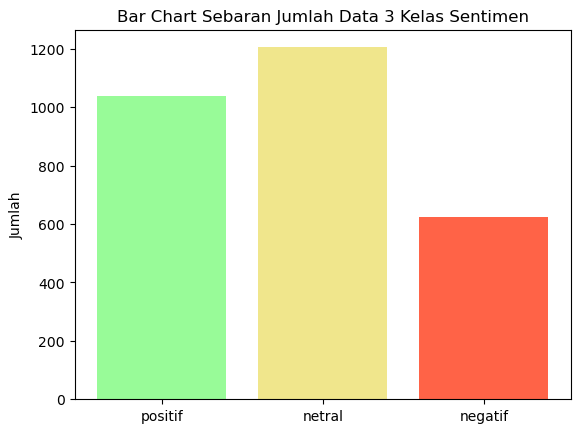

In [27]:
x_axis = ['positif', 'netral', 'negatif']
y_axis = [(sum(df['score']=='positif')), (sum(df['score']=='netral')), (sum(df['score']=='negatif'))]
c = ['palegreen','khaki','tomato']
plt.bar(x_axis, y_axis, color = c)
plt.title('Bar Chart Sebaran Jumlah Data 3 Kelas Sentimen')
plt.ylabel('Jumlah')
plt.show()

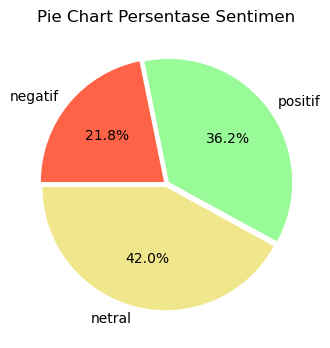

In [29]:
#Membuat PieChart
plt.figure(figsize=(8,4))
plt.title("Pie Chart Persentase Sentimen", fontsize=12)
chart = plt.pie(df.score.value_counts(),explode=(0.025,0.025,0.025), 
            labels=df.score.value_counts().index, 
            colors=['khaki','palegreen','tomato'],  
            autopct='%1.1f%%', startangle=180)
plt.show()

In [53]:
df.to_excel("label diagram lingkaran 2.xlsx")

### 4. Ekstraksi Fitur

In [54]:
# =========================================== EKSTRAKSI FITUR ===========================================
data = pd.read_excel('label diagram lingkaran 2.xlsx')
data

,Unnamed: 0,text,english,polarity,score
0,0,id iya sim pakai jaring telkomsel muncul byu,ID yes sim using Telkomsel network appears byu,0.000000,netral
1,1,id,id,0.000000,netral
2,2,sinyal telkomsel kinda pricey orang aware akti...,"Telkomsel's signal is kinda pricey, people are...",0.133333,positif
3,3,gaada id telkomsel gabgtu mahal banget nder ja...,"I don't have a Telkomsel ID, it's not very exp...",0.446154,positif
4,4,beneeeerrrrr enak banget byu huhuhu,really delicious byu huhuhu,1.000000,positif
...,...,...,...,...,...
2862,2862,byu telkomsel,Byu Telkomsel,0.000000,netral
2863,2863,byu bro telkomsel harga murahh gb bulan,Byu bro Telkomsel cheap prices GB month,0.400000,positif
2864,2864,fess hoo leh nganggo byu telkomsel gb wulan ew...,fess hoo leh nganggo byu telkomsel gb wulan ew...,0.000000,netral
2865,2865,id huhu maafin ya ganggu aktivitas kakak ayo l...,"ID huhu, sorry for disturbing your activities,...",-0.500000,negatif


In [55]:
df=pd.DataFrame(data)

Hal pertama yang dilakukan dalam tahap ini adalah membagi data menjadi dua bagian yaitu data latih dan data uji. Kode di bawah menghasilkan data uji atau _test size_ sebanyak 20% dari total keseluruhan data, dan sisanya yaitu 80% data menjadi data latih. Sehingga kode tersebut menghasilkan output 2293 data latih dan 574 data uji.

In [56]:
y=df.score.values
x=df.english.values

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, random_state=1,
                                    test_size=0.2, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(2293,)
(574,)


Tahap selanjutnya adalah mengubah isi dataset ke dalam representasi _vector_ sekaligus menerapkan _N-Gram_. Pada penelitian ini, digunakan library scikitlearn untuk mengambil _CountVectorizer_ yang dapat mengubah fitur teks menjadi sebuah representasi _vector_, kemudian parameter _N-Gram_ akan menyusun kata yang menjadi _bag of words_ berbentuk _unigram_. _Unigram_ artinya setiap representasi _vector_ akan mewakili 1 kata.

In [57]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(1,1), binary=True, stop_words='english')
vectorizer.fit(list(x_train) + list(x_test))

x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)
print(x_train_vec.shape)
print(x_test_vec.shape)

(2293, 3144)
(574, 3144)


### 5. Implementasi SVM
Tahap ini adalah tahap membuat model _Support Vector Machine classifier_. Pada data latih terdapat kelas sentiment positif, netral, dan negatif. SVM akan mempelajari karakteristik kata-kata yang terdapat pada masing-masing kelas pada data latih tersebut, kemudian SVM akan mencoba memprediksi kelas sentiment pada data uji sebanyak 800 data. Pada tahap pemodelan ini, dicoba tiga kernel SVM yaitu _Linear_, RBF, dan _Polynomial_ dengan nilai default pada C, _gamma_, dan _degree_ untuk mengetahui kernel apa yang paling baik akurasinya dalam mengklasifikasikan 4000 data pada penelitian ini. 

In [58]:
# =========================================== KLASIFIKASI SVM ===========================================
#Membuat Classifier SVM Linear
linear = svm.SVC(kernel='linear', C=1)
linear.fit(x_train_vec, y_train).predict(x_test_vec)

#Membuat Classifier SVM RBF
rbf = svm.SVC(kernel='rbf', gamma='scale', C=1)
rbf.fit(x_train_vec, y_train).predict(x_test_vec)

#Membuat Classifier SVM Polynomial
poly = svm.SVC(kernel='poly', degree=3, C=1)
poly.fit(x_train_vec, y_train).predict(x_test_vec)

array(['netral', 'netral', 'positif', 'netral', 'netral', 'positif',
       'netral', 'netral', 'netral', 'netral', 'netral', 'netral',
       'negatif', 'netral', 'netral', 'netral', 'netral', 'negatif',
       'netral', 'netral', 'positif', 'positif', 'netral', 'negatif',
       'positif', 'netral', 'netral', 'negatif', 'netral', 'netral',
       'netral', 'netral', 'netral', 'positif', 'netral', 'netral',
       'netral', 'netral', 'positif', 'netral', 'netral', 'positif',
       'netral', 'negatif', 'netral', 'netral', 'netral', 'netral',
       'negatif', 'positif', 'netral', 'netral', 'netral', 'netral',
       'netral', 'netral', 'netral', 'netral', 'netral', 'positif',
       'positif', 'netral', 'netral', 'netral', 'netral', 'netral',
       'netral', 'netral', 'positif', 'netral', 'positif', 'netral',
       'netral', 'netral', 'negatif', 'positif', 'negatif', 'netral',
       'netral', 'netral', 'netral', 'netral', 'positif', 'netral',
       'netral', 'netral', 'netral', 'p

In [59]:
linear_pred = linear.predict(x_test_vec)
rbf_pred = rbf.predict(x_test_vec)
poly_pred = poly.predict(x_test_vec)

In [60]:
score_linear = accuracy_score(linear_pred, y_test)
score_rbf = accuracy_score(rbf_pred, y_test)
score_poly = accuracy_score(poly_pred, y_test)

print("Accuracy with Linear SVM: ",score_linear * 100, '%')
print("Accuracy with RBF SVM: ",score_rbf * 100, '%')
print("Accuracy with Polynomial SVM: ",score_poly * 100, '%')

Accuracy with Linear SVM:  90.94076655052264 %
Accuracy with RBF SVM:  84.49477351916377 %
Accuracy with Polynomial SVM:  63.76306620209059 %


disimpulkan bahwa Linear SVM memiliki performa paling baik dalam menguji data tweet pada penelitian ini. Maka dari itu, kernel tersebut adalah kernel yang akan digunakan di penelitian ini untuk evaluasi performansi dan sekaligus menjadi classifier untuk aplikasi web analisis sentimen.

### 6. Evaluasi Performansi
Untuk mengetahui performa dari metode Linear SVM, maka dilakukan pengujian terhadap model yang telah dibuat. Hasil klasifikasi akan ditampilkan dalam bentuk _confusion matrix_. _Confusion matrix_ mengandung informasi yang membandingkan hasil klasifikasi yang dilakukan oleh sistem dengan hasil klasifikasi yang seharusnya.

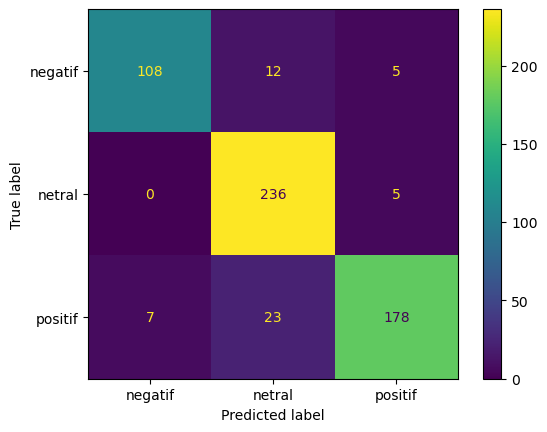

In [61]:
cm = confusion_matrix(y_test, linear_pred, labels=linear.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=linear.classes_)
disp.plot()
plt.show()

Model mengklasifikasikan 102 data negatif yang teridentifikasi dengan benar bersentimen negatif, 10 data negatif teridentifikasi netral, dan 47 data negatif teridentifikasi positif. 12 data netral benar teridentifikasi dengan benar bersentimen netral, 2 data netral teridentifikasi negatif, dan 13 data netral teridentifikasi positif. Kemudian 585 data positif teridentifikasi dengan benar bersentimen positif, 21 data positif teridentifikasi negatif, dan 8 data positif teridentifikasi netral.

In [62]:
print("Linear SVM Confusion Matrix: ")
print(confusion_matrix(y_test, linear_pred))

Linear SVM Confusion Matrix: 
[[108  12   5]
 [  0 236   5]
 [  7  23 178]]


In [63]:
print(classification_report(y_test, linear_pred))

              precision    recall  f1-score   support

     negatif       0.94      0.86      0.90       125
      netral       0.87      0.98      0.92       241
     positif       0.95      0.86      0.90       208

    accuracy                           0.91       574
   macro avg       0.92      0.90      0.91       574
weighted avg       0.91      0.91      0.91       574

